# `Практикум по программированию на языке Python`

## `Задание 03. Рекуррентные Нейронные Сети. Dropout. LM`

#### Фамилия, имя: Долгушев Глеб

Дата выдачи: <span style="color:red">__18 марта 23:59__</span>.

Мягкий дедлайн: <span style="color:red">__31 марта 05:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __7 баллов__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

Данное задание будет состоять из двух частей:
1. Применение рекуррентной сети для решения задачи классификации текста. Более конкретно -- предсказания рейтинга отзыва фильма.
2. Простейшая лингвистическая модель для генерации текста на основе LSTM.

При выполнении задания вы обучите LSTM с разным уровнем "коробочности", а также познакомитесь с различными способами применения DropOut к рекуррентным архитектурам. В рекуррентных архитектурах вариантов, куда можно наложить бинарную маску шума, гораздо больше, чем в нейросетях прямого прохода.

Во второй части вы попробуете реализовать простейший рекуррентный декодер для генерации текстов.

Задание сделано так, чтобы его можно было выполнять на CPU, однако RNN - это ресурсоёмкая вещь, поэтому на GPU с ними работать приятнее. Можете попробовать использовать [https://colab.research.google.com](https://colab.research.google.com) - бесплатное облако с GPU.

**Для корректного отображения картинок, вам может понадобится сделать ноутбук доверенным (Trusted) в правом верхнем углу**

# `Часть 0. Загрузка и предобработка данных (1 балл)`

## `Рекомендуемые гиперпараметры`

In [1]:
max_length = 200
top_n_words = 5000

hidden_dim = 128
embedding_dim = 32

num_epochs = 15
batch_size = 64
learning_rate = 1e-3

Первое, что нужно сделать — скачать, предобработать данные и организовать их таким образом, чтобы их можно было подавать в нейронную сеть.

Для обеих частей задания мы будем использовать [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/).

## `Загрузка и предобработка данных`

In [2]:
!pip install wget -q

  Preparing metadata (setup.py) ... done


Загрузите данные по ссылке выше. (**tip**: используйте `wget`)

In [3]:
import wget
import os

if not os.path.exists('./aclImdb_v1.tar.gz'):
    url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    wget.download(url)

Распакуйте скачанные данные в папку `aclImdb` (**tip:** используйте `tar`)

In [4]:
import tarfile

if not os.path.exists('aclImdb'):
    tar = tarfile.open("./aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()


Посмотрите в файле `./aclImdb/README` как организованы данные:

In [5]:
!cat ./aclImdb/train/pos/10003_8.txt

This is not the typical Mel Brooks film. It was much less slapstick than most of his movies and actually had a plot that was followable. Leslie Ann Warren made the movie, she is such a fantastic, under-rated actress. There were some moments that could have been fleshed out a bit more, and some scenes that could probably have been cut to make the room to do so, but all in all, this is worth the price to rent and see it. The acting was good overall, Brooks himself did a good job without his characteristic speaking to directly to the audience. Again, Warren was the best actor in the movie, but "Fume" and "Sailor" both played their parts well.

In [6]:
test_data_path = './aclImdb/test/'
train_data_path = './aclImdb/train/'

In [7]:
import random
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from typing import Optional, Tuple, Union, List

from IPython.display import Markdown, display


import nltk
nltk.download('stopwords')

import regex
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

import tokenizers
from tokenizers import Tokenizer, trainers, pre_tokenizers

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True

os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def check_numel(module: torch.nn.Module, params_numel: int, buffers_numel: Optional[int] = None) -> None:
    """Check whether module has correct number of parameters and buffers
    :param torch.nn.Module module: Target model
    :param int params_numel: Target number of parameters
    :param Optional[int] buffers_numel: Target number of buffers
    :rtype:
    """
    numel = sum(param.numel() for param in module.parameters())
    assert numel == params_numel, f'For params numel != correct numel: {numel} vs {params_numel}'

    if buffers_numel is not None:
        numel = sum(param.numel() for param in module.buffers())
        assert numel == buffers_numel, f'For buffers numel != correct numel: {numel} vs {buffers_numel}'


In [9]:
set_global_seed(42)

Стандартной предобработкой данных является токенизация текстов. Полученные токены можно будет закодировать и затем подавать на вход нейронной сети. Ключевым моментом, который влияет на скорость работы нейросети и её размер в памяти — размер словаря, используемого при токенизации. Для задачи классификации мы можем убрать часть слов (стоп слова, редкие слова), ускорив обучение без потери в качестве.

In [10]:
STOPWORDS = nltk.corpus.stopwords.words('english')

Реализуйте функцию для токенизации текста. Выполнять токенизацию можно по-разному, но в данном задании предлагается это делать следующим образом:
1. Привести текст к нижнему регистру
2. Убрать html разметку из текстов (`<br />`, ...)
3. Убрать все символы кроме латинских букв
4. Разбить строку по пробелам
5. Убрать стоп слова

In [11]:
import re
from html import unescape

def remove_html_tags(text):
    cleaned = re.sub(r'<[^>]+>', '', text)
    return unescape(cleaned)

def tokenize(text):
    """
    :param str text: Input text
    :return List[str]: List of words
    """
    # YOUR CODE HERE
    text = text.lower()
    text = remove_html_tags(text)
    text = re.sub(r'[^A-Za-z]', ' ', text)
    text = text.split()
    text = [word for word in text if word not in STOPWORDS]
    return text

In [12]:
tokenize('1. Hello <br />  words!!   I am program!  <br />')

['hello', 'words', 'program']

Теперь мы можем создать словарь, с помощью которого мы будем кодировать токены из текста в числа и наоборот. Для этого мы воспользуемся библиотекой [tokenizers](https://huggingface.co/docs/tokenizers/index)

Токенезация происходит через класс `tokenizer`. Для того чтобы получить `tokenizer` его надо сначала **обучить**, для этого нам необходимо использовать `tokenizers.trainers`. Так как мы будем работать на уровне слов, то выберем `tokenizers.trainers.WordLevelTrainer`.

Для работы с текстами нам необходимо зарезервировать два специальных токена:
1. `<pad>` для токена означающего паддинг
2. `<unk>` для токенов, которые отсутствуют в словаре
3. `<sos>` для токенов, которые обозначают начало последовательности (потребуется во второй части задания)
4. `<eos>` для токенов, которые обозначают конец последовательности (потребуется во второй части задания)

Для начала мы будем разбивать предложение по словам, для этого воспользуемся `trainers.WordLevelTrainer`. Будем рассматривать словарь размером `top_n_words` слов. Подробнее про различных `trainers` можно почитать в [документации](https://huggingface.co/docs/tokenizers/api/trainers), например, из коробки можно использовать BPE.

```python
trainers.WordLevelTrainer(self, /, *args, **kwargs)
Docstring:     
Trainer capable of training a WorldLevel model

Args:
    vocab_size (:obj:`int`, `optional`):
        The size of the final vocabulary, including all tokens and alphabet.

    min_frequency (:obj:`int`, `optional`):
        The minimum frequency a pair should have in order to be merged.

    show_progress (:obj:`bool`, `optional`):
        Whether to show progress bars while training.

    special_tokens (:obj:`List[Union[str, AddedToken]]`):
        A list of special tokens the model should know of.
```

Не забудьте добавить специальные токены. В первой части это токены, отвечающие за паддинг и слова, которых нет в словаре.

In [13]:
# YOUR CODE HERE
trainer = trainers.WordLevelTrainer(
    vocab_size=top_n_words,
    show_progress=True,
    special_tokens=['<pad>', '<unk>']
)

tokenizer = tokenizers.Tokenizer(
    model = tokenizers.models.WordLevel(unk_token='<unk>')
)

Обучить `tokenizers.Tokenizer` можно **двумя способами**:

- [указать список файлов и обучиться на них](https://huggingface.co/docs/tokenizers/pipeline), бывает полезно, когда датасет нельзя поместить в оперативную память;

- [обучиться из памяти](https://huggingface.co/docs/tokenizers/training_from_memory), то есть хранить датасет в оперативной памяти, бывает полезно при маленьких датасетах как наш.


Чтобы обучиться из файлов нам необходимо задать `tokenizers.normalizers.Normalizer` для нормализации строк (удаление лишних слов и символов), после чего необходимо задать `tokenizers.pre_tokenizers.PreTokenizer` для разделение строки на слова. Подробнее можно посмотреть [в этом примере](https://github.com/huggingface/tokenizers/blob/4383a25787cf366f5e8eaf12643b64f0ba548dc2/bindings/python/examples/custom_components.py). Такая сложность обусловленна тем, что `tokenizers` крайне много использует особенности ООП (объектно-ориентированного программирования).

Мы будем обучаться из памяти, поэтому нам необходимо сделать итератор, который пройдет по всем файлам и токенизирует текст в них их. Подробнее можно почитать [в официальной документации](https://huggingface.co/docs/tokenizers/training_from_memory).


In [14]:
def get_data_iterator():
    for path in ['./aclImdb/test/neg', './aclImdb/test/pos', './aclImdb/train/neg', './aclImdb/train/pos']:
        paths = sorted(list(os.listdir(path)))

        # YOUR CODE HERE
        for file_path in paths:
            text = open(os.path.join(path, file_path), 'r', encoding='utf-8', errors='ignore').read().strip()
            yield tokenize(text)

In [15]:
tokenizer.train_from_iterator(tqdm(get_data_iterator(), total=50000), trainer=trainer)

100%|██████████| 50000/50000 [00:43<00:00, 1139.32it/s]


Посмотрим на токены с наименьшим *id*. Обратим внимание, что специальные токены имеют наименьшие *id* по-умолчанию.

In [16]:
for i in range(10):
    token = tokenizer.id_to_token(i)
    print(f"ID = {i}, token = {token}")

ID = 0, token = <pad>
ID = 1, token = <unk>
ID = 2, token = movie
ID = 3, token = film
ID = 4, token = one
ID = 5, token = like
ID = 6, token = good
ID = 7, token = time
ID = 8, token = even
ID = 9, token = would


In [17]:
# assert tokenizer.get_vocab_size() == top_n_words

# assert tokenizer.id_to_token(464) == 'complete', f"token = {tokenizer.id_to_token(464)}"
# assert tokenizer.id_to_token(647) == 'typical',  f"token = {tokenizer.id_to_token(647)}"
# assert tokenizer.id_to_token(573) == 'fast',     f"token = {tokenizer.id_to_token(573)}"

**Важно:** При создании итератора мы сортировали файлы, поэтому результат при корретной реализации должен быть детерминированный.

Для кодирования предложений используется метод `encode`, так как мы самостоятельно описали функцию `tokenize`, то установим `is_pretokenized=True`.

In [18]:
result = tokenizer.encode(
    sequence        = tokenize('1. Hello <br /> words!! <br />'),
    is_pretokenized = True
)

print(result)
print("Tokens ids: ", result.ids)

Encoding(num_tokens=2, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Tokens ids:  [4773, 536]


Для декодирования, следует использовать метод `decode`, по умолчанию все специальные токены будут пропущены, то есть все токены `<unk>` будут пропущены.

In [19]:
decode_res = tokenizer.decode(
    ids                 = result.ids,
    skip_special_tokens = True
)
print(f"Decode result: {decode_res}")

Decode result: hello words


Теперь мы готовы создать обёртку-датасет для наших данных.

Необходимо добавить несколько опций, которые понадобятся во второй части задания:
1. Ограничение на максимальную длину текста в токенах. Если текст оказывается длиннее, то последние токены отбрасываются. Иметь ограничение на максимальную длину бывает полезно, так вы имеете гарантии, что во время обучения не засэмплируется очень большой батч, после которого упадет обучение с ошибкой **CUDA error: out of memory**. Кроме того, вы гарантированно знаете на контекстах какой длины обучалась модель, то есть если на валидации вам подасться текст большей длины, то он гарантировано будет отличаться от обучащей выборки.
2. Возможность добавить в специальные токены `<sos>`, `<eos>` в начало и конец токенизированного текста
    
**tips:**
1. В исходных данных рейтинг закодирован в названии файла в виде числа от $1$ до $10$. Для удобства, вычтите $1$, чтобы рейтинг был от $0$ до $9$

In [20]:
class LargeMovieReviewDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_len, pad_sos=False, pad_eos=False):
        """
        :param str data_path: Path to folder with one of the data splits (train or test)
        :param tokenizers.tokenizer: tokenizer with lookup_indices method
        :param int max_len: Maximum length of tokenized text
        :param bool pad_sos: If True pad sequence at the beginning with <sos>
        :param bool pad_eos: If True pad sequence at the end with <eos>
        """
        super().__init__()

        self.pad_sos = pad_sos
        if self.pad_sos:
            self.sos_id = tokenizer.token_to_id('<sos>')
        self.pad_eos = pad_eos
        if self.pad_eos:
            self.eos_id = tokenizer.token_to_id('<eos>')

        self.tokenizer = tokenizer
        self.max_len   = max_len
        self.data_path = data_path
        self.negative_path = os.path.join(data_path, 'neg')
        self.positive_path = os.path.join(data_path, 'pos')

        self.negative_paths = []
        self.positive_paths = []

        for file_path in os.listdir(self.negative_path):
            self.negative_paths.append(os.path.join(self.negative_path, file_path))

        for file_path in os.listdir(self.positive_path):
            self.positive_paths.append(os.path.join(self.positive_path, file_path))

        self.negative_paths = sorted(self.negative_paths)
        self.positive_paths = sorted(self.positive_paths)

        self.texts = []
        self.tokens = []
        self.ratings = []
        self.labels = [0] * len(self.negative_paths) + [1] * len(self.positive_paths)

        # Read each file in data_path, tokenize it, get tokens ids, its rating and store
        for path in tqdm(self.negative_paths + self.positive_paths):
            # YOUR CODE HERE
            with open(path, 'r') as file:
                text = file.readline()
                self.texts.append(text)
            tmp_tokens = self.tokenizer.encode(
                sequence=tokenize(text),
                is_pretokenized=True
            ).ids
            if self.pad_sos:
                tmp_tokens.insert(0, self.sos_id)
            if self.pad_eos:
                tmp_tokens = tmp_tokens[:max_len - 1]
                tmp_tokens.append(self.eos_id)
            else:
                tmp_tokens = tmp_tokens[:max_len]
            self.tokens.append(tmp_tokens)
            self.ratings.append(int(path[:-4].split('_')[1]) - 1)

    def __getitem__(self, idx):
        """
        :param int idx: index of object in dataset
        :return dict: Dictionary with all useful object data
            {
                'text' str: unprocessed text,
                'label' torch.Tensor(dtype=torch.long): sentiment of the text (0 for negative, 1 for positive)
                'rating' torch.Tensor(dtype=torch.long): rating of the text
                'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids for the text
                'tokens_len' torch.Tensor(dtype=torch.long): number of tokens
            }
        """
        # YOUR CODE HERE
        # Do not forget to add <sos> and <eos> if needed!

        tokens = torch.Tensor(self.tokens[idx]).to(torch.long)
        return {
            'text': self.texts[idx],
            'label': torch.tensor(self.labels[idx]).to(torch.long),
            'tokens': tokens,
            'tokens_len': torch.tensor(tokens.shape[0]).to(torch.long),
            'rating': torch.tensor(self.ratings[idx]).to(torch.long)
        }

    def __len__(self):
        """
        :return int: number of objects in dataset
        """
        # YOUR CODE HERE
        return len(self.labels)

Создайте датасеты для тестовой и обучающей выборки.

Обратите внимание, что для задачи классификации нам не потребуется дополнять текст с помощью `<sos>`, `<eos>`. Эти токены отвечают за обозначение начала последовательности (**start of sequence**) и её конца (**end of sequence**). При моделировании языка нам будет необходимо уметь понимать где начался и закончился текст. Например, предложения часто начинаются со слова **"однажды"** и крайне редко со слова **"щекотать"**, аналогично про конец предложения.

Не забудьте обрезать длинные тексты, передав параметр `max_length`.

In [21]:
# YOUR CODE HERE
path = './aclImdb'
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

test_dataset = LargeMovieReviewDataset(test_path, tokenizer, max_length)
train_dataset = LargeMovieReviewDataset(train_path, tokenizer, max_length)

100%|██████████| 25000/25000 [00:23<00:00, 1057.11it/s]


Посмотрим, как выглядит объект в датасете:

In [22]:
train_dataset[2]

{'text': "This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.",
 'label': tensor(0),
 'tokens': tensor([   3, 3099,   51,  159, 3535,   20, 3268,   74,  839,  400,    1,    1,
          440, 1061,    1,  146,  839,   44,    8,  599,   50,  263,

In [23]:
test_dataset[0]

{'text': "Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.",
 'label': tensor(0),
 'tokens': tensor([ 315,    1, 3238,    2,  117,  997, 1569, 1033,

Теперь нам нужно создать `DataLoader` для наших данных. `DataLoader` умеет из коробки объединять список объектов из датасета в один батч, даже когда датасет возвращает словарь тензоров. Однако, это работает только в случае когда все эти тензоры имеют один и тот же размер во всех батчах. В нашем случае, это не так, так как разные тексты могут иметь разную длину.

Чтобы обойти эту проблему у `DataLoader` есть параметр `collate_fn`, который позволяет задать функцию для объединения списка объектов в один батч.

**tips**
1. Обратите свое внимание на функцию `torch.stack`, она позволяет "застакать" элементы списка в тензор

Чтобы объединить несколько тензоров разной длины в один можно использовать функцию `torch.nn.utils.rnn.pad_sequence`. Такой формат позволит удобно передавать данные в rnn модель.

Обратите внимание на её аргументы:
1. `batch_first` определяет по какой оси "складывать" тензоры. Предпочтительнее использовать `batch_first=False` так как это может упростить выполнение задания в дальнейшем
2. `padding_value` — число, которое будет использоваться в качестве паддинга, чтобы сделать все тензоры одинаковой длины


In [24]:
elemets = [
    torch.tensor([1, 2, 3]),
    torch.tensor([4, 5]),
    torch.tensor([6, 7, 8, 9])
]

out_nbf = torch.nn.utils.rnn.pad_sequence(
    elemets,
    batch_first   = False,
    padding_value = -1
)

out_bf = torch.nn.utils.rnn.pad_sequence(
    elemets,
    batch_first   = True,
    padding_value = -1
)

print(f"batch_first=False")
print(f"Shape = {out_nbf.shape}")
print(out_nbf)

print(f"batch_first=True")
print(f"Shape = {out_bf.shape}")
print(out_bf)

batch_first=False
Shape = torch.Size([4, 3])
tensor([[ 1,  4,  6],
        [ 2,  5,  7],
        [ 3, -1,  8],
        [-1, -1,  9]])
batch_first=True
Shape = torch.Size([3, 4])
tensor([[ 1,  2,  3, -1],
        [ 4,  5, -1, -1],
        [ 6,  7,  8,  9]])


In [25]:
def collate_fn(batch, padding_value, batch_first=False):
    """
    :param List[Dict] batch: List of objects from dataset
    :param int padding_value: Value that will be used to pad tokens
    :param bool batch_first: If True resulting tensor with tokens must have shape [B, T] otherwise [T, B]
    :return dict: Dictionary with all data collated
        {
            'ratings' torch.Tensor(dtype=torch.long): rating of the text for each object in batch
            'labels' torch.Tensor(dtype=torch.long): sentiment of the text for each object in batch

            'texts' List[str]: All texts in one list
            'tokens' torch.Tensor(dtype=torch.long): tensor of tokens ids padded with @padding_value
            'tokens_lens' torch.Tensor(dtype=torch.long): number of tokens for each object in batch
        }
    """
    # YOUR CODE HERE
    res = {
        'ratings': [],
        'labels': [],
        'texts': [],
        'tokens': [],
        'tokens_lens': [],
    }

    for element in batch:
        for key in element.keys():
            if key == 'tokens':
                res[key].append(element[key])
            else:
                res[key + 's'].append(element[key])
    for key in res.keys():
        if key == 'tokens':
            res[key] = torch.nn.utils.rnn.pad_sequence(
                res[key],
                batch_first   = batch_first,
                padding_value = padding_value
            )
        elif key != 'texts':
            res[key] = torch.stack(res[key])
    return res

Создайте даталоадеры с использованием `collate_fn`.

**tips**:
1. Передать в `collate_fn` правильное значение паддинга можно, например, с помощью `functools.partial`
2. Если вы работаете в Google Colab, то, возможно, вам будет необходимо установить `num_workers=0` во избежание падения ноутбука.
3. Для определения индекса `<pad>` надо использовать `tokenizer.token_to_id('<pad>')`, а не магическую константу 0.

In [26]:
from functools import partial

# YOUR CODE HERE
padding_value = tokenizer.token_to_id('<pad>')
collate_fn = partial(collate_fn, padding_value=padding_value)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
)

Посмотрим на какой-нибудь батч:

In [27]:
batch = next(iter(test_dataloader))
batch.keys(), batch['labels'], batch['ratings'], batch['tokens'], batch['tokens_lens']

(dict_keys(['ratings', 'labels', 'texts', 'tokens', 'tokens_lens']),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 3, 0, 2, 2, 1, 1, 1, 3, 3, 2, 2, 1, 0, 0, 3, 1, 3, 2, 0, 0, 0, 3, 0,
         2, 3, 3, 2, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 0, 0,
         0, 1, 0, 3, 0, 0, 0, 3, 3, 1, 3, 3, 2, 0, 0, 0]),
 tensor([[ 315,  342,   20,  ..., 2230,  607,    1],
         [   1, 2080,  595,  ...,  127,    1,  282],
         [3238,  100, 4991,  ...,   58,  527,  474],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([ 73, 126, 110, 164, 139,  55,  77,  70,  72,  99,  58, 142, 142,  50,
         102, 114,  65, 115, 190,  47,  37,  93, 200, 200, 135, 107, 103, 20

# `Часть 1. Классификация текстов (4 балла)`

В этой части вы обучите классификатор текстов на основе рекуррентной нейронной сети. Выше мы уже создали удобные класс-обёртки для работы с данными. Теперь мы соберем модель для решения задачи классификации. Вам предлагается решить задачу предсказания **рейтинга фильма** (классы 0 до 9), то есть мы решаем задачу многоклассовой классификации.

## `Сборка и обучение RNN в pytorch (1 балл)`

Создадим переменные для device-agnostic кода:

In [28]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


Наша нейросеть будет обрабатывать входную последовательность по словам (word level). Мы будем использовать простую и стандартную рекуррентную архитектуру для классификации:
1. Слой представлений, превращающий id токена в вектор-эмбеддинг этого слова
2. Слой LSTM
3. Полносвязный слой, предсказывающий выход по последнему скрытому состоянию

Ниже дан код для сборки и обучения нашей нейросети.

Допишите класс-обёртку над LSTM для задачи классификации.
**Не используйте циклы.**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [29]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, tokenizer,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()

        self.dropout = dropout

        self.tokenizer = tokenizer
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim

        # Create a simple lookup table that stores embeddings of a fixed dictionary and size.
        #    Use torch.nn.Embedding. Do not forget specify padding_idx!
        # YOUR CODE HERE
        self.word_embeddings = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embedding_dim,
            padding_idx=tokenizer.token_to_id('<pad>')
        )

        # Add **kwargs in rec_layer constructor
        if dropout is not None:
            self.rnn = rec_layer(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                dropout=dropout,
                **kwargs
            )
        else:
            self.rnn = rec_layer(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                **kwargs
            )

        # Create linear layer for classification
        # YOUR CODE HERE
        self.output = torch.nn.Linear(hidden_dim, output_size)

    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.Tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.Tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        # Evaluate embeddings
        # YOUR CODE HERE
        # Length x Batch_sz -> Length x Batch_sz x Embedding_dim
        embeddings = self.word_embeddings(tokens)

        # Make forward pass through recurrent network
        # YOUR CODE HERE
        # Length x Batch_sz x Embedding_dim -> Length x Batch_sz x Hidden_dim, (... , ...)
        batch_sz = tokens.shape[1]
        out, (h_n, c_n) = self.rnn(embeddings)

        # Pass output from rnn to linear layer
        # Note: each object in batch has its own length
        #     so we must take rnn hidden state after the last token for each text in batch
        # YOUR CODE HERE
        # Batch_sz x Hidden_dim -> Batch_sz x Output_dim
        out = self.output(out[tokens_lens - 1, torch.arange(batch_sz), :])
        return out

[Исходный код LSTM](http://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html#LSTM)

Допишите функции для обучения и оценки модели:

**tip:**
1. В функции `evaluate` при подсчёте метрик учитывайте, что батчи могут иметь разный размер. (в частности последний батч)

**Важно:** Мы предсказываем `rating`, не `label`.

In [30]:
from time import perf_counter

def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        # 1. Take data from batch
        ratings = data['ratings'].to(device)
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        # 2. Perform forward pass
        output = model(tokens, tokens_lens)
        # 3. Evaluate loss
        loss = loss_fn(output, ratings)
        loss.backward()
        # 4. Make optimizer step
        optimizer.step()
        # YOUR CODE HERE

def evaluate(dataloader, model, loss_fn, device):
    model.eval()

    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            # 1. Take data from batch
            ratings = data['ratings'].to(device)
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            # 2. Perform forward pass
            output = model(tokens, tokens_lens)
            # 3. Evaluate loss
            loss = loss_fn(output, ratings)
            total_loss += loss.item() * ratings.shape[0]
            # 4. Evaluate accuracy
            total_accuracy += torch.sum(ratings == torch.argmax(output, dim=1))
            # YOUR CODE HERE

    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)


def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    train_time = perf_counter()
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)

        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    train_time = perf_counter() - train_time
    res_dct = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'train_time': train_time,
    }
    return res_dct

Создадим модель:

In [ ]:
set_global_seed(42)

model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=torch.nn.LSTM, dropout=None
).to(device)

check_numel(model, 244234, 0)

Создадим класс для подсчёта функции потерь и оптимизатор:

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Попробуем обучить модель:

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

**Возможно стоит сохранить результаты в виде файлов и скачать их**

**Обратите внимание, что надо сохранить и время**

In [ ]:
base_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(base_res, 'base_res')

Epoch: 1/15. Loss (Train/Test): 2.008/2.011. Accuracy (Train/Test): 0.233/0.236
Epoch: 2/15. Loss (Train/Test): 1.663/1.706. Accuracy (Train/Test): 0.362/0.348
Epoch: 3/15. Loss (Train/Test): 1.535/1.618. Accuracy (Train/Test): 0.405/0.377
Epoch: 4/15. Loss (Train/Test): 1.473/1.592. Accuracy (Train/Test): 0.423/0.390
Epoch: 5/15. Loss (Train/Test): 1.411/1.571. Accuracy (Train/Test): 0.451/0.389
Epoch: 6/15. Loss (Train/Test): 1.349/1.575. Accuracy (Train/Test): 0.468/0.398
Epoch: 7/15. Loss (Train/Test): 1.290/1.574. Accuracy (Train/Test): 0.486/0.402
Epoch: 8/15. Loss (Train/Test): 1.232/1.589. Accuracy (Train/Test): 0.513/0.397
Epoch: 9/15. Loss (Train/Test): 1.169/1.616. Accuracy (Train/Test): 0.541/0.396
Epoch: 10/15. Loss (Train/Test): 1.113/1.651. Accuracy (Train/Test): 0.564/0.387
Epoch: 11/15. Loss (Train/Test): 1.033/1.716. Accuracy (Train/Test): 0.604/0.378
Epoch: 12/15. Loss (Train/Test): 0.967/1.763. Accuracy (Train/Test): 0.641/0.367
Epoch: 13/15. Loss (Train/Test): 0.88

Нерегуляризованные LSTM часто быстро переобучаются (и мы это видим по точности на контроле). Чтобы с этим бороться, часто используют *L2-регуляризацию* и *дропаут*.
Однако способов накладывать дропаут на рекуррентный слой достаточно много, и далеко не все хорошо работают. По [ссылке](https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b) доступен хороший обзор дропаутов для RNN.

Мы реализуем два варианта DropOut для RNN (и третий дополнительно). Заодно увидим, что для реализации различных усовершенствований рекуррентной архитектуры приходится "вскрывать" слой до различной "глубины".

## `Реализация дропаута по статье Гала и Гарамани. Variational Dropout (1 балл)`

Начнем с дропаута, описанного в [статье Гала и Гарамани](https://arxiv.org/abs/1512.05287).
Для этого нам потребуется перейти от использования слоя `torch.nn.LSTM`, полностью скрывающего от нас рекуррентную логику, к использованию слоя `torch.nn.LSTMCell`, обрабатывающего лишь один временной шаг нашей последовательности (а всю логику вокруг придется реализовать самостоятельно).

Для начала напишем функцию, которая позволит нам получать $h_0$ и $c_0$, которые мы будем использовать в качестве инициализаций.

**tips:**

1. Используйте some_existing_tensor, как тензор в котором содержится информация о типе данных, девайсе целевого тензора. Обратите внимание на функцию [new_ones](https://pytorch.org/docs/stable/generated/torch.Tensor.new_ones.html).

In [31]:
def init_h0_c0(num_objects, hidden_size, some_existing_tensor):
    """
    return h0 and c0, use some_existing_tensor.new_zeros() to gen them
    h0 shape: num_objects x hidden_size
    c0 shape: num_objects x hidden_size
    """
    # YOUR CODE HERE
    h_0 = some_existing_tensor.new_zeros(
        (num_objects, hidden_size)
    )
    c_0 = some_existing_tensor.new_zeros(
        (num_objects, hidden_size)
    )
    return h_0, c_0

Допишите класс `RNNLayer`. При `dropout=0` ваш класс должен работать как обычный слой LSTM, а при `dropout > 0` накладывать бинарную маску на входной и скрытый вектор на каждом временном шаге, причем эта маска должна быть одинаковой во все моменты времени.

Дропаут Гала и Гарамани в виде формул (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o)
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad
g = tanh(h_{t-1} W^g + x_t U^g+b_g)
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

**Важно**: Мы считаем, что объекты в батче независимы, то есть маски для них должны быть разные.

**tips:**

1. Для получения бернулливской случайной величины достаточно вызвать `.bernoulli()` от массива содержащего вероятности.


In [32]:
def gen_dropout_mask(input_size, hidden_size, is_training, p, some_existing_tensor):
    """
    is_training: if True, gen masks from Bernoulli
                 if False, gen masks consisting of (1-p)

    return dropout masks of size input_size, hidden_size if p is not None
    return one masks if p is None
    """
    if p is None:
        p = 0.
    probs = some_existing_tensor.new_ones((input_size, hidden_size)) * (1 - p)
    if is_training:
        return probs.bernoulli()
    else:
        return probs

In [33]:
set_global_seed(42)
p = 0.12
m = gen_dropout_mask(100, 120, is_training=True, p=p, some_existing_tensor=torch.tensor(1.))


print(f'm.mean(): {m.mean():0.4f}')
assert m.shape == (100, 120)
assert (1 - p) - 0.005 <= m.mean() <= (1 - p) + 0.005

m.mean(): 0.8808


Допишите класс-обёртку над `LSTMCell` для реализации Variational Dropout. **Используйте только цикл по времени**

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [34]:
class RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=None):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn_cell = torch.nn.LSTMCell(self.input_size, self.hidden_size)

    def forward(self, x):
        # Initialize h_0, c_0
        # YOUR CODE HERE
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)

        # Gen masks for input and hidden state
        # YOUR CODE HERE
        masks_h = gen_dropout_mask(x.shape[1], self.hidden_size, self.training, self.dropout, x)
        masks_x = gen_dropout_mask(x.shape[1], self.input_size, self.training, self.dropout, x)

        # Implement recurrent logic and return what nn.LSTM returns
        # Do not forget to apply generated dropout masks!
        # YOUR CODE HERE
        # Length x Batch_sz x input_size
        h_t, c_t = h_0, c_0
        output = []

        for i in range(x.shape[0]):
            h_t, x_masked = h_t * masks_h, x[i] * masks_x
            h_t, c_t = self.rnn_cell(x_masked, (h_t, c_t))
            output.append(h_t)
        output = torch.stack(output, dim=0)
        return output, (h_t, c_t)

In [35]:
layer = RNNLayer(32, 64, dropout=None)
dummy_input = torch.ones((10, 16, 32))

out = layer(dummy_input)

assert out[0].shape == (10, 16, 64)
assert out[1][0].shape == (16, 64)
assert out[1][1].shape == (16, 64)

Протестируйте реализованную модель с выключенным дропаутом (слой `RNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Сильно ли оно увеличилось по сравнению с `torch.nn.LSTM` (LSTM "из коробки")?

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

**Возможно стоит сохранить результаты в виде файлов и скачать их**

In [ ]:
set_global_seed(42)

# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=RNNLayer, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

var_drop_check_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(var_drop_check_res, 'var_drop_check_res')

Epoch: 1/15. Loss (Train/Test): 2.014/2.016. Accuracy (Train/Test): 0.225/0.229
Epoch: 2/15. Loss (Train/Test): 1.699/1.739. Accuracy (Train/Test): 0.349/0.342
Epoch: 3/15. Loss (Train/Test): 1.555/1.626. Accuracy (Train/Test): 0.401/0.374
Epoch: 4/15. Loss (Train/Test): 1.482/1.596. Accuracy (Train/Test): 0.418/0.382
Epoch: 5/15. Loss (Train/Test): 1.421/1.574. Accuracy (Train/Test): 0.447/0.386
Epoch: 6/15. Loss (Train/Test): 1.361/1.587. Accuracy (Train/Test): 0.462/0.394
Epoch: 7/15. Loss (Train/Test): 1.302/1.563. Accuracy (Train/Test): 0.485/0.398
Epoch: 8/15. Loss (Train/Test): 1.239/1.590. Accuracy (Train/Test): 0.511/0.395
Epoch: 9/15. Loss (Train/Test): 1.176/1.618. Accuracy (Train/Test): 0.538/0.393
Epoch: 10/15. Loss (Train/Test): 1.124/1.653. Accuracy (Train/Test): 0.559/0.388
Epoch: 11/15. Loss (Train/Test): 1.041/1.709. Accuracy (Train/Test): 0.602/0.378
Epoch: 12/15. Loss (Train/Test): 0.987/1.751. Accuracy (Train/Test): 0.636/0.361
Epoch: 13/15. Loss (Train/Test): 0.89

In [ ]:
print(f"Training time for pure LSTM: {base_res['train_time']:.3f} s")
print(f"Training time for custom LSTM: {var_drop_check_res['train_time']:.3f} s")

Training time for pure LSTM: 108.634 s
Training time for custom LSTM: 629.048 s


Протестируйте полученную модель с `dropout=0.25`, вновь замерив время обучения. Получилось ли побороть переобучение? Сильно ли дольше обучается данная модель по сравнению с предыдущей? (доп. время тратится на генерацию масок дропаута).

In [ ]:
set_global_seed(42)

# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=RNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

var_drop_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(var_drop_res, 'var_drop_res')

Epoch: 1/15. Loss (Train/Test): 2.017/2.018. Accuracy (Train/Test): 0.223/0.225
Epoch: 2/15. Loss (Train/Test): 1.863/1.878. Accuracy (Train/Test): 0.311/0.312
Epoch: 3/15. Loss (Train/Test): 1.647/1.682. Accuracy (Train/Test): 0.373/0.355
Epoch: 4/15. Loss (Train/Test): 1.578/1.622. Accuracy (Train/Test): 0.385/0.374
Epoch: 5/15. Loss (Train/Test): 1.530/1.592. Accuracy (Train/Test): 0.407/0.387
Epoch: 6/15. Loss (Train/Test): 1.472/1.564. Accuracy (Train/Test): 0.425/0.388
Epoch: 7/15. Loss (Train/Test): 1.430/1.534. Accuracy (Train/Test): 0.438/0.403
Epoch: 8/15. Loss (Train/Test): 1.402/1.524. Accuracy (Train/Test): 0.450/0.406
Epoch: 9/15. Loss (Train/Test): 1.389/1.527. Accuracy (Train/Test): 0.455/0.404
Epoch: 10/15. Loss (Train/Test): 1.357/1.514. Accuracy (Train/Test): 0.467/0.408
Epoch: 11/15. Loss (Train/Test): 1.335/1.505. Accuracy (Train/Test): 0.476/0.411
Epoch: 12/15. Loss (Train/Test): 1.319/1.507. Accuracy (Train/Test): 0.479/0.413
Epoch: 13/15. Loss (Train/Test): 1.29

In [ ]:
print(f"Training time for pure LSTM: {base_res['train_time']:.3f} s")
print(f"Training time for custom LSTM without dropout: {var_drop_check_res['train_time']:.3f} s")
print(f"Training time for custom LSTM with dropout: {var_drop_res['train_time']:.3f} s")

Training time for pure LSTM: 108.634 s
Training time for custom LSTM without dropout: 629.048 s
Training time for custom LSTM with dropout: 646.167 s


---

**Вывод:** Добавление дропаута действительно помогло увеличить качество на валидации и побороть переобучение, при этом время обучения увеличилось незначительно

## `Реализация дропаута по статье Гала и Гарамани. Дубль 2 (1 балл)`

<начало взлома pytorch>

При разворачивании цикла по времени средствами python обучение рекуррентной нейросети сильно замедляется. Однако для реализации дропаута Гала и Гарамани необязательно явно задавать в коде умножение нейронов на маски. Можно схитрить и обойтись использованием слоя `torch.nn.LSTM`: перед вызовом `forward` слоя `torch.nn.LSTM` подменять его веса на веса, домноженные **по строкам** на маски. А обучаемые веса хранить отдельно. Именно так этот дропаут реализован в библиотеке `fastai`, код из которой использован в ячейке ниже.

Благодаря такому подходу мы используем быстрый код слоя `torch.nn.LSTM`, который гарантировано написан хорошо и правильно, но подменяем веса так, чтобы получить необходимый эффект.

Для начала посмотрим на стандартный слой `nn.LSTM` и вспомним дропаут Гала и Гарамани (m обозначает маску дропаута):

$$
h_{t-1} = h_{t-1}*m_h, \, x_t = x_t * m_x
$$

Далее обычный шаг рекуррентной архитектуры, например, LSTM:

$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o)
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad
g = tanh(h_{t-1} W^g + x_t U^g+b_g)
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$

Сначал посмотрим на параметры слоя `nn.LSTM`.

In [36]:
lstm = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=2)

for tag, p in lstm.named_parameters():
    print(f"{tag:<12}: {p.shape}")

weight_ih_l0: torch.Size([512, 32])
weight_hh_l0: torch.Size([512, 128])
bias_ih_l0  : torch.Size([512])
bias_hh_l0  : torch.Size([512])
weight_ih_l1: torch.Size([512, 128])
weight_hh_l1: torch.Size([512, 128])
bias_ih_l1  : torch.Size([512])
bias_hh_l1  : torch.Size([512])


Подробнее про каждый отдельный модуль можно почитать на [официальной странице](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), важно, что умножая каждую строку весов **weight\_\*\*\_\*\*** на маску, мы получим те же вычисления, что и при умножении $h_{t-1}$ и $x_t$ на маску. Для проверки этого факта рассмотрим игрушечный пример:

In [37]:
set_global_seed(42)

W = torch.randn((hidden_dim * 4, hidden_dim))
x = torch.arange(hidden_dim).float()
mask = (torch.arange(hidden_dim) % 2 == 0).long()

res1 = W @ (x * mask)

res2 = (W * mask[None, :]) @ x

torch.isclose(res1, res2).all()

tensor(True)

Реализуйте слой, который с помощью подмены весов реализует  дропаут Гала и Гарамани, в виде обертки над `torch.nn.LSTM`. Допишите класс:

In [38]:
import warnings

In [39]:
class FastRNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0, layers_dropout=0.0, num_layers=1):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dropout = dropout
        self.layers_dropout = layers_dropout
        self.module = torch.nn.LSTM(input_size, hidden_size, dropout=layers_dropout, num_layers=num_layers)

        self.layer_names = []
        for layer_n in range(self.num_layers):
            self.layer_names += [f'weight_hh_l{layer_n}', f'weight_ih_l{layer_n}']

        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights from torch.nn.LSTM instance
            w = getattr(self.module, layer)

            # Remove it from model
            delattr(self.module, layer)

            # And create new torch.nn.Parameter with the same data but different name
            self.register_parameter(f'{layer}_raw', torch.nn.Parameter(w.data))

            # Note. In torch.nn.LSTM.forward parameter with name `layer` will be used
            #     so we must initialize it using `layer_raw` before forward pass

    def _setweights(self, x):
        """
            Apply dropout to the raw weights.
        """
        for layer in self.layer_names:
            # Get torch.nn.Parameter with weights
            raw_w = getattr(self, f'{layer}_raw')

            # Generate mask (use function gen_dropout_mask)
            # YOUR CODE HERE

            # Apply dropout mask
            # YOUR CODE HERE
            if layer.startswith('weight_hh'):
                masks = gen_dropout_mask(1, self.hidden_size, self.training, self.dropout, x)
            elif layer.startswith('weight_ih'):
                masks = gen_dropout_mask(1, self.input_size, self.training, self.dropout, x)
            masked_raw_w = masks * raw_w

            # Set modified weights in its place
            setattr(self.module, layer, masked_raw_w)

    def forward(self, x, h_c=None):
        """
        :param x: tensor containing the features of the input sequence.
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        with warnings.catch_warnings():
            # To avoid the warning that comes because the weights aren't flattened.
            warnings.simplefilter("ignore")

            # Set new weights of self.module and call its forward
            # Pass h_c with x if it is not None. Otherwise pass only x
            # YOUR CODE HERE
            self._setweights(x)
            if h_c is None:
                return self.module(x)
            else:
                return self.module(x)

    def reset(self):
        if hasattr(self.module, 'reset'):
            self.module.reset()

In [40]:
layer = FastRNNLayer(32, 64, dropout=None)
dummy_input = torch.ones((10, 16, 32))

out = layer(dummy_input)

assert out[0].shape == (10, 16, 64)
assert out[1][0].shape == (1, 16, 64)
assert out[1][1].shape == (1, 16, 64)

Протестируйте реализованную модель с выключенным дропаутом (слой `FastRNNLayer` надо передать в `RNNClassifier` в качестве `rec_layer`). Замерьте время обучения. Убедитесь, что модель выдаёт такое же качество, как и оригинальная реализация LSTM.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

**Возможно стоит сохранить результаты в виде файлов и скачать их**

In [ ]:
set_global_seed(42)

# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=FastRNNLayer, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

fast_var_drop_check_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(fast_var_drop_check_res, 'fast_var_drop_check_res')

Epoch: 1/15. Loss (Train/Test): 2.008/2.011. Accuracy (Train/Test): 0.233/0.236
Epoch: 2/15. Loss (Train/Test): 1.663/1.706. Accuracy (Train/Test): 0.362/0.348
Epoch: 3/15. Loss (Train/Test): 1.535/1.618. Accuracy (Train/Test): 0.405/0.377
Epoch: 4/15. Loss (Train/Test): 1.473/1.592. Accuracy (Train/Test): 0.423/0.390
Epoch: 5/15. Loss (Train/Test): 1.411/1.571. Accuracy (Train/Test): 0.451/0.389
Epoch: 6/15. Loss (Train/Test): 1.349/1.575. Accuracy (Train/Test): 0.468/0.398
Epoch: 7/15. Loss (Train/Test): 1.290/1.574. Accuracy (Train/Test): 0.486/0.402
Epoch: 8/15. Loss (Train/Test): 1.232/1.589. Accuracy (Train/Test): 0.513/0.397
Epoch: 9/15. Loss (Train/Test): 1.169/1.616. Accuracy (Train/Test): 0.541/0.396
Epoch: 10/15. Loss (Train/Test): 1.113/1.651. Accuracy (Train/Test): 0.564/0.387
Epoch: 11/15. Loss (Train/Test): 1.033/1.716. Accuracy (Train/Test): 0.604/0.378
Epoch: 12/15. Loss (Train/Test): 0.967/1.763. Accuracy (Train/Test): 0.641/0.367
Epoch: 13/15. Loss (Train/Test): 0.88

In [ ]:
print(f"Training time for pure LSTM: {base_res['train_time']:.3f} s")
print(f"Training time for custom LSTM: {var_drop_check_res['train_time']:.3f} s")
print(f"Training time for custom LSTM with hacks: {fast_var_drop_check_res['train_time']:.3f} s")

Training time for pure LSTM: 108.634 s
Training time for custom LSTM: 629.048 s
Training time for custom LSTM with hacks: 117.966 s


In [ ]:
print(f"Best accuracy of pure LSTM: {float(max(base_res['test_accuracies'])):.3f}")
print(f"Best accuracy of custom LSTM: {float(max(var_drop_check_res['test_accuracies'])):.3f}")
print(f"Best accuracy of fast custom LSTM: {float(max(fast_var_drop_check_res['test_accuracies'])):.3f}")

# assert max(var_drop_check_res['test_accuracies']) == max(fast_var_drop_check_res['test_accuracies'])
# assert max(base_res['test_accuracies']) == max(fast_var_drop_check_res['test_accuracies'])

Best accuracy of pure LSTM: 0.402
Best accuracy of custom LSTM: 0.398
Best accuracy of fast custom LSTM: 0.402


Протестируйте полученный слой (вновь подставив его в `RNNClassifier` в качестве `rec_layer`) с `dropout=0.25`. Сравните время обучения с предыдущими моделями. Проследите, чтобы качество получилось такое же, как при первой реализации этого дропаута.

In [ ]:
set_global_seed(42)

# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=FastRNNLayer, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

fast_var_drop_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(fast_var_drop_res, 'fast_var_drop_res')

Epoch: 1/15. Loss (Train/Test): 2.009/2.011. Accuracy (Train/Test): 0.223/0.230
Epoch: 2/15. Loss (Train/Test): 1.777/1.803. Accuracy (Train/Test): 0.330/0.329
Epoch: 3/15. Loss (Train/Test): 1.649/1.686. Accuracy (Train/Test): 0.369/0.359
Epoch: 4/15. Loss (Train/Test): 1.563/1.616. Accuracy (Train/Test): 0.390/0.377
Epoch: 5/15. Loss (Train/Test): 1.516/1.583. Accuracy (Train/Test): 0.406/0.388
Epoch: 6/15. Loss (Train/Test): 1.483/1.579. Accuracy (Train/Test): 0.420/0.387
Epoch: 7/15. Loss (Train/Test): 1.432/1.539. Accuracy (Train/Test): 0.435/0.402
Epoch: 8/15. Loss (Train/Test): 1.410/1.526. Accuracy (Train/Test): 0.445/0.406
Epoch: 9/15. Loss (Train/Test): 1.386/1.526. Accuracy (Train/Test): 0.459/0.401
Epoch: 10/15. Loss (Train/Test): 1.364/1.521. Accuracy (Train/Test): 0.464/0.406
Epoch: 11/15. Loss (Train/Test): 1.343/1.510. Accuracy (Train/Test): 0.472/0.410
Epoch: 12/15. Loss (Train/Test): 1.321/1.508. Accuracy (Train/Test): 0.477/0.412
Epoch: 13/15. Loss (Train/Test): 1.29

In [ ]:
print(f"Training time for pure LSTM: {base_res['train_time']:.3f} s")
print(f"Training time for custom LSTM without dropout: {var_drop_check_res['train_time']:.3f} s")
print(f"Training time for custom LSTM with dropout: {var_drop_res['train_time']:.3f} s")
print(f"Training time for custom LSTM without dropout with hacks: {fast_var_drop_check_res['train_time']:.3f} s")
print(f"Training time for custom LSTM with dropout with hacks: {fast_var_drop_res['train_time']:.3f} s")

Training time for pure LSTM: 108.634 s
Training time for custom LSTM without dropout: 629.048 s
Training time for custom LSTM with dropout: 646.167 s
Training time for custom LSTM without dropout with hacks: 117.966 s
Training time for custom LSTM with dropout with hacks: 117.610 s


In [ ]:
print(f"Best accuracy of custom LSTM with dropout: {float(max(var_drop_res['test_accuracies'])):.3f}")
print(f"Best accuracy of fast custom LSTM with dropout: {float(max(fast_var_drop_res['test_accuracies'])):.3f}")

# assert max(var_drop_res['test_accuracies']) == max(fast_var_drop_res['test_accuracies'])

Best accuracy of custom LSTM with dropout: 0.413
Best accuracy of fast custom LSTM with dropout: 0.412


---

**Вывод:** Как видим, время обучения уменьшилось почти в 6 раз, при этом качество похоже. Из-за того что в первой реализации мы применяли к каждому элементу батча свою максу, а при быстрой вариации дропаута - одну и ту же качество в первом случае получилось лучше (сильнее регуляризация)

</конец взлома pytorch>

## `Реализация дропаута по статье Семениуты и др. (1 балл)`

Перейдем к реализации дропаута для LSTM по статье [Semeniuta et al](http://www.aclweb.org/anthology/C16-1165).

Этот метод применения дропаута не менее популярен, чем предыдущий. Его особенность состоит в том, что он придуман специально для гейтовых архитектур. В контексте LSTM этот дропаут накладывается только на информационный поток ($m_h$ — маска дропаута):
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o)
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad
g = tanh(h_{t-1} W^g + x_t U^g+b_g)
$$
$$
c_t = f \odot c_{t-1} +  i \odot g \odot {\bf m_h} \quad
h_t =  o \odot tanh(c_t)
$$
**На входы $x_t$ маска накладывается как в предыдущем дропауте.** Впрочем, на входы маску можно наложить вообще до вызова рекуррентного слоя.

Согласно статье, маска дропаута может быть как одинаковая, так и разная для всех моментов времени. Мы сделаем одинаковую для всех моментов времени.

Для реализации этого дропаута можно:
1. самостоятельно реализовать LSTM (интерфейса LSTMCell не хватит)
2. снова воспользоваться трюком с установкой весов (но тут мы опираемся на свойство $tanh(0)=0$, к тому же, трюк в данном случае выглядит менее тривиально, чем с дропаутом Гала).

**Внимание:** Раньше мы реализовывали через LSTMCell и модель работала долго, теперь при рукописном варианте будет работать еще дольше!

Предлагается реализовать дропаут по сценарию 1. Допишите класс:

**Для каждого тензора в функции `forward` подпишите в комментарии его размеры**

In [41]:
class HandmadeLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.0):
        super().__init__()

        self.dropout = dropout
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input_weights = torch.nn.Linear(input_size, 4 * hidden_size)
        self.hidden_weights = torch.nn.Linear(hidden_size, 4 * hidden_size)

        self.reset_params()

    def reset_params(self):
        """
        Initialization as in Pytorch.
        Do not forget to call this method!
        https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#LSTM
        """
        stdv = 1.0 / np.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, x):
        # Use functions init_h0_c0 and gen_dropout_masks defined above
        # YOUR CODE HERE
        h_0, c_0 = init_h0_c0(x.shape[1], self.hidden_size, x)
        masks_h = gen_dropout_mask(1, self.hidden_size, self.training, self.dropout, x)
        masks_x = gen_dropout_mask(1, self.input_size, self.training, self.dropout, x)

        # Implement recurrent logic to mimic torch.nn.LSTM
        # Do not forget to apply dropout mask
        # YOUR CODE HERE
        h_t, c_t = h_0, c_0
        output = []

        for i in range(x.shape[0]):
            x_masked = x[i] * masks_x
            gates_h = self.hidden_weights(h_t)
            gates_x = self.input_weights(x_masked)
            gates = gates_h + gates_x

            i = torch.sigmoid(gates[:, :self.hidden_size])
            f = torch.sigmoid(gates[:, self.hidden_size:2 * self.hidden_size])
            o = torch.sigmoid(gates[:, 2 * self.hidden_size:3 * self.hidden_size])
            g = torch.tanh(gates[:, 3 * self.hidden_size:4 * self.hidden_size])

            c_t = f * c_t + i * g * masks_h
            h_t = o * torch.tanh(c_t)
            output.append(h_t)
        output = torch.stack(output, dim=0)
        return output, (h_t, c_t)

In [42]:
layer = HandmadeLSTM(32, 64, dropout=None)
dummy_input = torch.ones((10, 16, 32))

out = layer(dummy_input)

assert out[0].shape == (10, 16, 64)
assert out[1][0].shape == (16, 64)
assert out[1][1].shape == (16, 64)

Протестируйте вашу реализацию без дропаута (проконтролируйте качество и сравните время обучения с временем обучения `torch.nn.LSTM` и `RNNLayer`), а также с `dropout=0.25`. Сравните качество модели с таким дропаутом с качеством модели с дропаутом Гала и Гарамани.

**Сохраните все метрики и время работы модели. Это потребуется в конце первой части для построения графиков обучения и сравнения времени работы для всех моделей в этой секции**

**Возможно стоит сохранить результаты в виде файлов и скачать их**

In [ ]:
set_global_seed(42)

# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=HandmadeLSTM, dropout=None
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

handmade_check_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(handmade_check_res, 'handmade_check_res')

Epoch: 1/15. Loss (Train/Test): 1.990/1.994. Accuracy (Train/Test): 0.240/0.234
Epoch: 2/15. Loss (Train/Test): 1.671/1.720. Accuracy (Train/Test): 0.360/0.347
Epoch: 3/15. Loss (Train/Test): 1.558/1.645. Accuracy (Train/Test): 0.393/0.368
Epoch: 4/15. Loss (Train/Test): 1.510/1.614. Accuracy (Train/Test): 0.411/0.379
Epoch: 5/15. Loss (Train/Test): 1.451/1.614. Accuracy (Train/Test): 0.432/0.385
Epoch: 6/15. Loss (Train/Test): 1.377/1.586. Accuracy (Train/Test): 0.458/0.389
Epoch: 7/15. Loss (Train/Test): 1.307/1.577. Accuracy (Train/Test): 0.485/0.394
Epoch: 8/15. Loss (Train/Test): 1.261/1.597. Accuracy (Train/Test): 0.507/0.386
Epoch: 9/15. Loss (Train/Test): 1.199/1.612. Accuracy (Train/Test): 0.530/0.389
Epoch: 10/15. Loss (Train/Test): 1.147/1.659. Accuracy (Train/Test): 0.553/0.382
Epoch: 11/15. Loss (Train/Test): 1.051/1.699. Accuracy (Train/Test): 0.598/0.377
Epoch: 12/15. Loss (Train/Test): 0.977/1.773. Accuracy (Train/Test): 0.634/0.374
Epoch: 13/15. Loss (Train/Test): 0.89

In [ ]:
print(f"Training time for pure LSTM: {base_res['train_time']:.3f} s")
print(f"Training time for custom LSTM: {var_drop_check_res['train_time']:.3f} s")
print(f"Training time for custom LSTM with hacks: {fast_var_drop_check_res['train_time']:.3f} s")
print(f"Training time for handmade LSTM: {handmade_check_res['train_time']:.3f} s")

Training time for pure LSTM: 108.634 s
Training time for custom LSTM: 629.048 s
Training time for custom LSTM with hacks: 117.966 s
Training time for handmade LSTM: 1646.543 s


In [ ]:
print(f"Best accuracy of pure LSTM (GG): {float(max(base_res['test_accuracies'])):.3f}")
print(f"Best accuracy of custom LSTM: {float(max(var_drop_check_res['test_accuracies'])):.3f}")
print(f"Best accuracy of fast custom LSTM: {float(max(fast_var_drop_check_res['test_accuracies'])):.3f}")
print(f"Best accuracy of handmade LSTM: {float(max(handmade_check_res['test_accuracies'])):.3f}")

Best accuracy of pure LSTM (GG): 0.402
Best accuracy of custom LSTM: 0.398
Best accuracy of fast custom LSTM: 0.402
Best accuracy of handmade LSTM: 0.394


---

**Примечание:** у нас получилось качество ниже, чем у предыдущих моделей, так как реализация не предполагала bias

In [ ]:
set_global_seed(42)

# YOUR CODE HERE
model = RNNClassifier(
    embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=10, tokenizer=tokenizer,
    rec_layer=HandmadeLSTM, dropout=0.25
).to(device)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

handmade_res = train(
    train_dataloader, test_dataloader, model, loss_fn, optimizer, device, num_epochs
)
torch.save(handmade_res, 'handmade_res')

Epoch: 1/15. Loss (Train/Test): 2.014/2.015. Accuracy (Train/Test): 0.226/0.223
Epoch: 2/15. Loss (Train/Test): 1.918/1.924. Accuracy (Train/Test): 0.275/0.283
Epoch: 3/15. Loss (Train/Test): 1.793/1.806. Accuracy (Train/Test): 0.333/0.337
Epoch: 4/15. Loss (Train/Test): 1.627/1.662. Accuracy (Train/Test): 0.372/0.366
Epoch: 5/15. Loss (Train/Test): 1.591/1.647. Accuracy (Train/Test): 0.375/0.358
Epoch: 6/15. Loss (Train/Test): 1.552/1.620. Accuracy (Train/Test): 0.393/0.369
Epoch: 7/15. Loss (Train/Test): 1.522/1.597. Accuracy (Train/Test): 0.400/0.383
Epoch: 8/15. Loss (Train/Test): 1.484/1.568. Accuracy (Train/Test): 0.415/0.391
Epoch: 9/15. Loss (Train/Test): 1.448/1.549. Accuracy (Train/Test): 0.426/0.398
Epoch: 10/15. Loss (Train/Test): 1.441/1.553. Accuracy (Train/Test): 0.428/0.399
Epoch: 11/15. Loss (Train/Test): 1.402/1.538. Accuracy (Train/Test): 0.444/0.401
Epoch: 12/15. Loss (Train/Test): 1.381/1.520. Accuracy (Train/Test): 0.451/0.406
Epoch: 13/15. Loss (Train/Test): 1.36

In [ ]:
print(f"Training time for pure LSTM: {base_res['train_time']:.3f} s")
print(f"Training time for LSTM (GG) without dropout: {var_drop_check_res['train_time']:.3f} s")
print(f"Training time for LSTM (GG) with dropout: {var_drop_res['train_time']:.3f} s")
print(f"Training time for LSTM (GG) without dropout with hacks: {fast_var_drop_check_res['train_time']:.3f} s")
print(f"Training time for LSTM (GG) with dropout with hacks: {fast_var_drop_res['train_time']:.3f} s")
print(f"Training time for LSTM (Semeniuta) without dropout: {handmade_check_res['train_time']:.3f} s")
print(f"Training time for LSTM (Semeniuta) with dropout: {handmade_res['train_time']:.3f} s")

Training time for pure LSTM: 108.634 s
Training time for LSTM (GG) without dropout: 629.048 s
Training time for LSTM (GG) with dropout: 646.167 s
Training time for LSTM (GG) without dropout with hacks: 117.966 s
Training time for LSTM (GG) with dropout with hacks: 117.610 s
Training time for LSTM (Semeniuta) without dropout: 1646.543 s
Training time for LSTM (Semeniuta) with dropout: 1629.871 s


In [ ]:
print(f"Best accuracy of LSTM (GG) with dropout: {float(max(var_drop_res['test_accuracies'])):.3f}")
print(f"Best accuracy of LSTM (Semeniuta) with dropout: {float(max(handmade_res['test_accuracies'])):.3f}")

Best accuracy of LSTM (GG) with dropout: 0.413
Best accuracy of LSTM (Semeniuta) with dropout: 0.409


---

**Вывод:** С реализацией дропаута Семиуты качество получилось ниже, что можно опять же связать с отсутствием `bias` при вычислении гейтов в нашей самописной LSTM.

## `Сравнение всех предложенных моделей (1 балл)`

Используя замеры времени заполните табличку с временем работы четырёх реализованных моделей в следующей ячейке:

| torch.nn.LSTM | RNNLayer | FastRNNLayer | HandmadeLSTM |
|---------------|----------|--------------|--------------|
| 1m 49s        | 10m 29s  | 1m 58s       | 27m 27s      |

In [ ]:
import matplotlib.pyplot as plt

Крайне желательно рисовать графики в векторном формате.

Если по каким-то причинам, отрисовка не будет работать, закомментируйте следующую ячейку.

In [ ]:
%matplotlib inline

import matplotlib_inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Нарисуйте два графика — функция потерь и качество на обучающей и тестовой выборке для всех 7 моделей обученных выше.

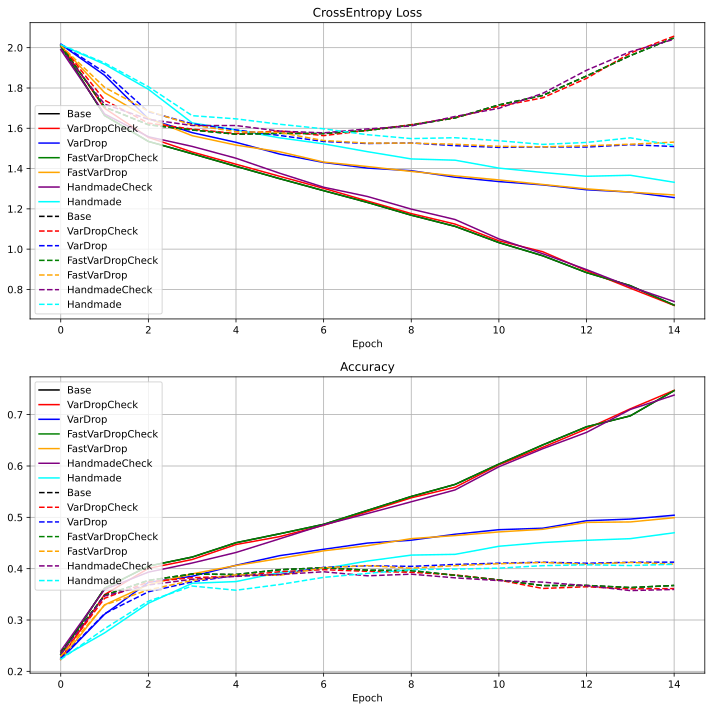

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
colors = ['black', 'red', 'blue', 'green', 'orange', 'purple', 'cyan']

# YOUR CODE HERE
labels = ['Base', 'VarDropCheck', 'VarDrop', 'FastVarDropCheck', 'FastVarDrop', 'HandmadeCheck', 'Handmade']
results = [base_res, var_drop_check_res, var_drop_res, fast_var_drop_check_res, fast_var_drop_res, handmade_check_res, handmade_res]

for res, label, color in zip(results, labels, colors):
    axes[0].plot(torch.tensor(res['train_losses']).cpu(), c=color, label=label, linestyle='-')
    axes[1].plot(torch.tensor(res['train_accuracies']).cpu(), c=color, label=label, linestyle='-')

for res, label, color in zip(results, labels, colors):
    axes[0].plot(torch.tensor(res['test_losses']).cpu(), c=color, label=label, linestyle='--')
    axes[1].plot(torch.tensor(res['test_accuracies']).cpu(), c=color, label=label, linestyle='--')


axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.savefig("results.pdf")
plt.show()

Сделайте итоговые выводы о качестве работы моделей с разными реализациями DropOut:

**Ответ:** Краткие выводы уже были приведены выше.

1. Без использования дропаутов LSTM действительно очень сильно переобучается и, как следствие, выдает меньшее качество на валидации.
2. Использование дропаутов исправляет эту проблему, качество значительно растет, разница между качеством на валидации и трейне уменьшается.
3. Лучше всего себя показала самая первая реализация дропаута Гала и Гарамани, так как имеет более сильную регуляризацию по сравнению с быстрой реализацией, и при этом основывается на базовой LSTM модели.

## `Бонус. Zoneout (0.5 балла)`

Это еще одна модификация идеи дропаута применительно к рекуррентным нейросетям. В Zoneout на каждом временном шаге с вероятностью $p$ компонента скрытого состояния обновляется, а с вероятностью $1-p$ берется с предыдущего шага.
В Виде формул ($m^t_h$ - бинарная маска):

(сначала обычный рекуррентный переход, например LSTM)
$$
i = \sigma(h_{t-1}W^i + x_t U^i+b_i) \quad
o = \sigma(h_{t-1}W^o + x_t U^o+b_o)
$$
$$
f = \sigma(h_{t-1}W^f + x_t U^f+b_f) \quad
g = tanh(h_{t-1} W^g + x_t U^g+b_g)
$$
$$
c_t = f \odot c_{t-1} +  i \odot  g \quad
h_t =  o \odot tanh(c_t)
$$
Затем Zoneout:
$$
h_t = h_t * m_h^t + h_{t-1}*(1-m_h^t)
$$
В этом методе маска уже должна быть разная во все моменты времени (иначе метод упрощается до дропаута Гала и Гарамани). На входы $x_t$ вновь можно накладывать маску до начала работы рекуррентного слоя.  

Если у вас осталось время, вы можете реализовать этот метод. Выберите основу из трех рассмотренных случаев самостоятельно.

**Полный балл ставится только при наличии качественного и количественного сравнения с предыдущими моделями.**

# `Часть 2. Language Modeling с помощью LSTM (5 баллов)`

Во второй части мы попробуем обучить модель для генерации отзывов по их началу.

Концептуально модель будет выглядеть следующим образом:
    
![image info](https://www.researchgate.net/publication/350391597/figure/fig1/AS:1005416683167744@1616721425265/Structure-of-the-long-short-term-memory-language-model-LSTMLM.png)

В процессе обучения будем тренировать сеть предсказывать вероятность следующего символа при условии всех предыдущих. Эту вероятность можно моделировать с помощью скрытого состояния $h^{(t)}$ пропуская его через линейный слой с выходной размерностью равной размерности словаря:
$$
p(x^{t}|x^{t-1}, ..., x^{1}) = SoftMax(Linear(h^{(t)}))
$$

Обратите внимание, что для вычисления $p(x^{t}|x^{t-1}, ..., x^{1})$ для всех моментов времени достаточно сделать один проход по RNN, а затем применить линейное преобразование ко всем скрытым состояниям.

В качестве функции потерь необходимо использовать `CrossEntropy`.

Рассмотрим другой важный момент. Для того, чтобы решить данную задачу, модель должна уметь определять момент начала генерации предложения и оповещать о завершении генерации — конце предложения. Для этого добавим в словарь вспомогательные токены `<sos>`, `<eos>`. Добавив `<sos>` в начало каждого предложения и `<eos>` в конец.

Модель сможет начинать генерацию как только ей будет передан токен `<sos>` и заканчивать генерацию, как только на очередном месте самым вероятным токеном оказывается `<eos>`.

Для решения этой задачи мы воспользуемся уже реализованной LSTM с дропаутом `FastRNNLayer` и классом `RNNClassifier`, то есть архитектура сети принципиально не поменяется.

## `Реализация модели и цикла обучения (2 балла)`

**Не используйте циклы в `RNNLM`, `LMCrossEntropyLoss`, `LMAccuracy`**

In [43]:
class RNNLM(RNNClassifier):
    def __init__(
        self, embedding_dim, hidden_dim, tokenizer, dropout=0.5, layers_dropout=0.5, num_layers=1
    ):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim,
            output_size=tokenizer.get_vocab_size(), tokenizer=tokenizer,
            rec_layer=FastRNNLayer, dropout=dropout, layers_dropout=layers_dropout, num_layers=num_layers
        )

    def forward(self, tokens, tokens_lens):
        """
        :param torch.Tensor(dtype=torch.long) tokens:
            Batch of texts represented with tokens. Shape: [T, B]
        :param torch.Tensor(dtype=torch.long) tokens_lens:
            Number of non-padding tokens for each object in batch. Shape: [B]
        :return torch.Tensor:
            Distribution of next token for each time step. Shape: [T, B, V], V — size of vocabulary
        """
        # Make embeddings for all tokens
        # YOUR CODE HERE
        embeddings = self.word_embeddings(tokens)

        # Forward pass embeddings through network
        # YOUR CODE HERE
        batch_sz = tokens.shape[1]
        out, (h_n, c_n) = self.rnn(embeddings)

        # Take all hidden states from the last layer of LSTM for each step and perform linear transformation
        # YOUR CODE HERE
        out = self.output(out)
        return out

Реализуем функцию потерь для данной задачи.

Моменты на которые нужно обратить внимание:
1. Распределение вероятности следующего токена для последнего токена в последовательности не участвует в подсчёте функции потерь.
2. Необходимо учитывать, что в одном батче могут быть тексты разной длины.

Для решения второй проблемы можно воспользоваться функцией `torch.nn.utils.rnn.pack_padded_sequence`.

Принимая на вход батч тензоров и длину каждого тензора без учёта паддинга эта функция позволяет получить все элементы в тензорах, которые не относятся к паддингу в виде плоского массива:

In [44]:
padded_tensors = torch.tensor([
    [[1, 11, 111], [2, 22, 222], [3, 33, 333]],
    [[4, 44, 444], [5, 55, 555], [6, 66, 666]],
    [[7, 77, 777], [0, 0, 0], [8, 88, 888]],
    [[9, 99, 999], [0, 0, 0], [0, 0, 0]]
])
tensors_lens = torch.tensor([4, 2, 3])

Обратите внимание, что `torch.nn.utils.rnn.pack_padded_sequence` автоматически переупорядочивает тензоры в батче по убыванию их длины.

In [45]:
torch.nn.utils.rnn.pack_padded_sequence(padded_tensors, tensors_lens, batch_first=False, enforce_sorted=False)

PackedSequence(data=tensor([[  1,  11, 111],
        [  3,  33, 333],
        [  2,  22, 222],
        [  4,  44, 444],
        [  6,  66, 666],
        [  5,  55, 555],
        [  7,  77, 777],
        [  8,  88, 888],
        [  9,  99, 999]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [46]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: CrossEntropyLoss between corresponding logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(
            outputs,
            torch.clip(tokens_lens - 1, min=0).cpu(),
            batch_first=False,
            enforce_sorted=False
        )
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(
            tokens[1:],
            torch.clip(tokens_lens - 1, min=0).cpu(),
            batch_first=False,
            enforce_sorted=False
        )

        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        return super().forward(packed_outputs.data, packed_tokens.data)

Проверим как работает класс `LMCrossEntropyLoss`. Важно помнить, что при языковом моделировании мы предсказываем следующий токен, то есть `tokens` и `outputs` смещены друг относительно друга.

In [47]:
loss = LMCrossEntropyLoss(reduction='none')
max_len_testing    = 3
batch_size_testing = 2
vocab_size_testing = 5

logits = torch.zeros((max_len_testing, batch_size_testing, vocab_size_testing))
tokens = torch.zeros((max_len_testing, batch_size_testing)).long()
lens   = torch.tensor([2, 3])

logits[:, 0, 0] = torch.tensor([1, -1, 0])
logits[:, 0, 1] = torch.tensor([2, 3,  0])
logits[:, 0, 2] = torch.tensor([3, 2,  0])
logits[:, 0, 3] = torch.tensor([4, 2,  0])
logits[:, 0, 4] = torch.tensor([5, 2,  0])


logits[:, 1, 0] = torch.tensor([-1, 10, 2])
logits[:, 1, 1] = torch.tensor([2, 30,  1])
logits[:, 1, 2] = torch.tensor([4, 20,  1])
logits[:, 1, 3] = torch.tensor([5, -10, 4])
logits[:, 1, 4] = torch.tensor([1, 7,  13])

tokens[:, 0]    = torch.tensor([1, 4, 0])
tokens[:, 1]    = torch.tensor([3, 1, 4])


loss(outputs=logits, tokens=tokens, tokens_lens=lens)

tensor([ 3.3636,  0.4519, 23.0000])

Для оценки качества нам также необходимо вычислять долю правильно предсказанных токенов. Реализуйте класс для вычисления точности.

In [48]:
class LMAccuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, tokens, tokens_lens):
        """
        :param torch.Tensor outputs: Output from RNNLM.forward. Shape: [T, B, V]
        :param torch.Tensor tokens: Batch of tokens. Shape: [T, B]
        :param torch.Tensor tokens_lens: Length of each sequence in batch
        :return torch.Tensor: Accuracy for given logits and tokens
        """
        # Use torch.nn.utils.rnn.pack_padded_sequence().data to remove padding and flatten logits and tokens
        # Do not forget specify enforce_sorted=False and correct value of batch_first
        # YOUR CODE HERE
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(
            outputs,
            torch.clip(tokens_lens - 1, min=0).cpu(),
            batch_first=False,
            enforce_sorted=False
        )
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(
            tokens[1:],
            torch.clip(tokens_lens - 1, min=0).cpu(),
            batch_first=False,
            enforce_sorted=False
        )

        # Use super().forward(..., ...) to compute CrossEntropyLoss
        # YOUR CODE HERE
        preds = torch.argmax(packed_outputs.data, dim=1)
        return torch.sum(preds == packed_tokens.data) / preds.shape[0]

Проверим как работает класс `LMAccuracy`.

In [49]:
metric = LMAccuracy()
max_len_testing    = 3
batch_size_testing = 2
vocab_size_testing = 5

logits = torch.zeros((max_len_testing, batch_size_testing, vocab_size_testing))
tokens = torch.zeros((max_len_testing, batch_size_testing)).long()
lens   = torch.tensor([2, 3])

logits[:, 0, 0] = torch.tensor([1, -1, 0])
logits[:, 0, 1] = torch.tensor([2, 3,  0])
logits[:, 0, 2] = torch.tensor([3, 2,  0])
logits[:, 0, 3] = torch.tensor([4, 2,  0])
logits[:, 0, 4] = torch.tensor([5, 2,  0])


logits[:, 1, 0] = torch.tensor([-1, 10, 2])
logits[:, 1, 1] = torch.tensor([2, 30,  1])
logits[:, 1, 2] = torch.tensor([4, 20,  1])
logits[:, 1, 3] = torch.tensor([5, -10, 4])
logits[:, 1, 4] = torch.tensor([1, 7,  13])

tokens[:, 0]    = torch.tensor([1, 4, 0])
tokens[:, 1]    = torch.tensor([3, 1, 4])


metric(outputs=logits, tokens=tokens, tokens_lens=lens)

tensor(0.3333)

In [50]:
metric = LMAccuracy()
max_len_testing    = 10
batch_size_testing = 3
vocab_size_testing = 200

set_global_seed(42)
logits = torch.randn((max_len_testing, batch_size_testing, vocab_size_testing))
logits[:, :, 1] = 1000

tokens = torch.randint(low=0, high=vocab_size_testing, size=(max_len_testing, batch_size_testing))
tokens[:5, :] = 1
lens   = torch.tensor([10, 4, 9])

assert metric(outputs=logits, tokens=tokens, tokens_lens=lens) == (4 + 3 + 4) / (lens - 1).sum()

Модифицируйте функции `train_epoch`, `evaluate`, `train` для обучения LM.

**При вычислении точности, обратите внимание на то, что мы не предсказываем первый токен в каждой последовательности и токены, относящиеся к паддингу.**

In [51]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        # 1. Take data from batch
        tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens']
        # 2. Perform forward pass
        out = model(tokens, tokens_lens)
        # 3. Evaluate loss
        loss = loss_fn(out, tokens, tokens_lens)
        # 4. Make optimizer step
        loss.backward()
        optimizer.step()

def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()

    total_tokens = 0
    total_loss = 0.0
    total_accuracy = 0.0

    accuracy_fn = LMAccuracy()
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
             # 1. Take data from batch
            tokens, tokens_lens = data['tokens'].to(device), data['tokens_lens']
            # 2. Perform forward pass
            out = model(tokens, tokens_lens)
            # 3. Evaluate loss
            total_loss += loss_fn(out, tokens, tokens_lens).item() * (tokens_lens - 1).sum().item()
            # 4. Evaluate accuracy
            total_accuracy += accuracy_fn(out, tokens, tokens_lens).item() * (tokens_lens - 1).sum().item()
            total_tokens += (tokens_lens - 1).sum().item()

    return total_loss / total_tokens, total_accuracy / total_tokens

def train_lm(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    train_time = perf_counter()
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)

        train_loss, train_acc = evaluate_lm(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        test_loss, test_acc = evaluate_lm(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        print(
            'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
            )
        )
    train_time = perf_counter() - train_time
    res_dct = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'train_time': train_time,
    }
    return res_dct

Теперь у нас всё готово для обучения модели.

Создадим токенизатор с `<sos>`, `<eos>` токенами.

Обратите внимание, что в отличие от классификации текстов нам необходимо значительно увеличить размер словаря, чтобы доля `<unk>` токенов была не велика.

Так же, так как задача генерации значительно сложнее задачи классификации текстов будем обучать модель только на префиксах рецензий длины $20$. Это позволяет значительно ускорить обучение.

In [52]:
# min_freq=8 is approximately equivalent to max_size=30000.
#   You can lower min_freq in order to make model vocabulary more diverse
trainer = trainers.WordLevelTrainer(
    min_frequency  = 8,
    special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>'],
)

tokenizer = tokenizers.Tokenizer(
    model = tokenizers.models.WordLevel(unk_token="<unk>")
)

In [53]:
tokenizer.train_from_iterator(tqdm(get_data_iterator(), total=50_000), trainer=trainer)

100%|██████████| 50000/50000 [00:37<00:00, 1345.83it/s]


In [54]:
assert tokenizer.get_vocab_size() == 30000

for i in range(10):
    token = tokenizer.id_to_token(i)
    print(f"ID = {i}, token = {token}")


ID = 0, token = <pad>
ID = 1, token = <unk>
ID = 2, token = <sos>
ID = 3, token = <eos>
ID = 4, token = movie
ID = 5, token = film
ID = 6, token = one
ID = 7, token = like
ID = 8, token = good
ID = 9, token = time


In [55]:
lm_test_dataset = LargeMovieReviewDataset(test_data_path, tokenizer, max_len=20, pad_sos=True, pad_eos=True)
lm_train_dataset = LargeMovieReviewDataset(train_data_path, tokenizer, max_len=20, pad_sos=True, pad_eos=True)

100%|██████████| 25000/25000 [00:30<00:00, 821.02it/s] 


Создадим даталоадеры для тестовой и обучающей выборок:

In [56]:
lm_test_dataloader = DataLoader(
    lm_test_dataset, batch_size=196, shuffle=False, num_workers=0,
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)
lm_train_dataloader = DataLoader(
    lm_train_dataset, batch_size=196, shuffle=True, num_workers=0,
    collate_fn=partial(collate_fn, padding_value=tokenizer.token_to_id('<pad>'))
)

Убедитесь, что все предложения имеют в начале `<sos>` токен, а в конце — `<eos>` токен.

In [57]:
batch = next(iter(lm_train_dataloader))
batch['tokens'], batch['tokens_lens']

(tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [    5,     4,    44,  ...,   872,   106, 24597],
         [   67,   221,   135,  ...,    63,     1, 16021],
         ...,
         [18324,  2178,  3214,  ...,  3387,  7180,  6159],
         [  207,    12, 14698,  ...,   763,     6,   989],
         [    3,     3,     3,  ...,     3,     3,     3]]),
 tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

Создадим модель, функцию потерь и оптимизатор:

In [58]:
lm_model = RNNLM(
    embedding_dim=512, hidden_dim=512, tokenizer=tokenizer, dropout=0.6, layers_dropout=0.6, num_layers=2
).to(device=device)

In [59]:
lm_loss_fn = LMCrossEntropyLoss(reduction='mean')
lm_optimizer = torch.optim.Adam(lm_model.parameters(), lr=0.005, weight_decay=1.2e-6)

Обучим модель:

In [60]:
%%time
lm_model = torch.compile(lm_model)

CPU times: user 2.53 s, sys: 105 ms, total: 2.63 s
Wall time: 4.31 s


In [61]:
lm_res = train_lm(
    lm_train_dataloader, lm_test_dataloader, lm_model, lm_loss_fn, lm_optimizer, device, 10
)
torch.save(lm_res, 'lm_res')

W0404 09:37:15.548000 654 torch/_inductor/utils.py:1137] [4/0] Not enough SMs to use max_autotune_gemm mode


Epoch: 1/10. Loss (Train/Test): 7.603/7.729. Accuracy (Train/Test): 0.074/0.074
Epoch: 2/10. Loss (Train/Test): 7.508/7.669. Accuracy (Train/Test): 0.082/0.082
Epoch: 3/10. Loss (Train/Test): 7.383/7.603. Accuracy (Train/Test): 0.087/0.086
Epoch: 4/10. Loss (Train/Test): 7.195/7.486. Accuracy (Train/Test): 0.091/0.090
Epoch: 5/10. Loss (Train/Test): 7.022/7.412. Accuracy (Train/Test): 0.095/0.094
Epoch: 6/10. Loss (Train/Test): 6.865/7.375. Accuracy (Train/Test): 0.099/0.097
Epoch: 7/10. Loss (Train/Test): 6.712/7.355. Accuracy (Train/Test): 0.102/0.099
Epoch: 8/10. Loss (Train/Test): 6.556/7.345. Accuracy (Train/Test): 0.104/0.100
Epoch: 9/10. Loss (Train/Test): 6.392/7.368. Accuracy (Train/Test): 0.107/0.101
Epoch: 10/10. Loss (Train/Test): 6.249/7.400. Accuracy (Train/Test): 0.110/0.103


## `Реализация декодера (1 балл)`

Теперь, реализуем последнюю деталь — декодирование с использованием обученной модели.
Есть несколько вариантов. Рассмотрим два самых простых:
1. **Жадное декодирование.** На каждом шаге мы выбираем токен с максимальной вероятностью и используем его для обновления скрытого состояния RNN.
2. **Top-k sampling.** На очередном шаге рассматриваются $k$ токенов с самыми большими вероятностями. Остальные токены игнорируются. Из выбранных токенов семплируется следующий токен пропорционально их вероятностям.

Прочитать подробнее про разные варианты декодирования можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate)
2. [На towardsdatascience](https://towardsdatascience.com/decoding-strategies-that-you-need-to-know-for-response-generation-ba95ee0faadc)

Существенным в процессе декодирования является критерий останова. Как только очередной самый вероятный символ оказался `<eos>`, то данная последовательность считается сгенерированной. Однако, может так оказаться, что `<eos>` никогда не будет выбран, тогда необходимо прекратить генерацию, как только длина последовательности перейдёт порог `max_generated_len`.

In [62]:
@torch.no_grad()
def decode(
    model, start_tokens, start_tokens_lens,
    max_generated_len=20, top_k=None, eos_idx=tokenizer.token_to_id('<eos>')
):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum lenght of generated samples
    :param Optional[int] top_k: Number of tokens with the largest probability to sample from
    :return Tuple[torch.Tensor, torch.Tensor].
        Newly predicted tokens and length of generated part. Shape [T*, B], [B]
    """
    # Get embedding for start_tokens
    # YOUR CODE HERE
    embedding = model.word_embeddings(start_tokens)
    # Pass embedding through rnn and collect hidden states and cell states for each time moment
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        # YOUR CODE HERE
        _, (h, c) = model.rnn(embedding[time_step][None, :, :], (h, c))
        all_h.append(h)
        all_c.append(c)

    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]

    # List of predicted tokens for each time step
    predicted_tokens = []
    # Length of generated part for each object in the batch
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    # Boolean mask where we store if the sequence has already generated
    # i.e. `<eos>` was selected on any step
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)

    # Stop when all sequences in the batch are finished
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        # Evaluate next token distribution using hidden state h.
        # Note. Over first dimension h has hidden states for each layer of LSTM.
        #     We must use hidden state from the last layer
        # YOUR CODE HERE
        logits = model.output(h[-1])
        if top_k is not None:
            # Top-k sampling. Use only top-k most probable logits to sample next token
            indices_to_remove = logits < torch.topk(logits, top_k)[0][:, -1, None]
            # Mask non top-k logits
            logits[indices_to_remove] = -1e10
            # Sample next_token.
            # YOUR CODE HERE
            probs = logits.softmax(dim=-1)
            next_token = probs.multinomial(1)[:, 0]
        else:
            # Select most probable token
            # YOUR CODE HERE
            next_token = logits.argmax(dim=-1)
        predicted_tokens.append(next_token)

        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(eos_idx))

        # Compute embedding for next token
        # YOUR CODE HERE
        embedding = model.word_embeddings(next_token)

        # Update hidden and cell states
        # YOUR CODE HERE
        _, (h, c) = model.rnn(embedding[None, :, :], (h, c))

    return torch.stack(predicted_tokens), decoded_lens

Для тестирования создадим удобный класс `FakeLM`, который будет реализовывать весь необходимый функционал, а именно:

- `word_embeddings` - по токенам возвращает их эмбеддинги;

- `output` - по вектору контекста (h) возвращает вероятности следующих токенов;

- `rnn` - обновляет контекст. Будем использовать класс `FakeRNN`.

Для простоты будем считать, что эмбеддинг токена и есть сам токен, а процесс генерации является марковским, то есть все переходы можно описать матрицей.

Такая постановка поможет нам удобно задать все переходы и нарисовать их на бумаге (если возникнет необходимость в отладке). Кроме того, мы можем не думать об обновлении контекста, так как контекст и есть текущее слово (его эмбеддинг).

In [63]:
class FakeRNN:
    def __init__(self):
        self.num_layers = 1

    def __call__(self, embedding, h_c):
        """
        :param torch.Tensor embedding: Batch of embedding. Shape: [T, B, E]
        :param Optional[Tuple[torch.Tensor, torch.Tensor]] h_c: initial hidden state and initial cell state
        """
        return None, (embedding, torch.zeros_like(embedding))


class FakeLM:
    def __init__(self, rnn, transition_matrix):
        self.rnn = rnn
        self.transition_matrix = transition_matrix
        self.hidden_dim = 1

    def word_embeddings(self, tokens):
        """
        :param torch.Tensor tokens: Batch of seed tokens. Shape: [T, B] or [B]
        :return torch.Tensor
            Batch of tokens embeddings. Shape: [T, BS, E] or [B, E]
        """
        return tokens[..., None].float()

    def output(self, h):
        """
        :param torch.Tensor h: Batch of seed tokens. Shape: [B, E]
        :return torch.Tensor.
            Batch of new_tokens logits. Shape: [B, V]
        """
        idx  = h.long().ravel().cpu().numpy()
        logits = list(self.transition_matrix[i] for i in idx)
        logits = torch.stack(logits, dim=0).float()
        return logits


#### `Тест 1`

Зададим переходную матрицу `transitions` так, чтобы после токена $i$ вероятней всего следовал токен $i + 1$ mod $V$, где $V$ размер словаря. Тогда мы ожидаем получить циклические последовательности.

In [64]:
transitions = {
    0: torch.tensor([4, 5, 0, 0, 0]),
    1: torch.tensor([0, 4, 5, 0, 0]),
    2: torch.tensor([0, 0, 4, 5, 0]),
    3: torch.tensor([0, 0, 0, 4, 5]),
    4: torch.tensor([5, 0, 0, 0, 4]),
}

fake_lm = FakeLM(FakeRNN(), transitions)

In [65]:
decoded_tokens, decoded_lens = decode(
    model             = fake_lm,
    start_tokens      = torch.zeros((4, 3)),
    start_tokens_lens = torch.tensor([1, 2, 3]),
    eos_idx           = 10,
    max_generated_len = 8
)


In [66]:
assert decoded_tokens.shape == (8, 3), f"Shape = {decoded_tokens.shape}"
assert (decoded_tokens[:, 0] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()
assert (decoded_tokens[:, 1] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()
assert (decoded_tokens[:, 2] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()

#### `Тест 2`

Усложним и зададим разные начальные токены.

In [67]:
start_tokens = torch.tensor(
    [
        [0, 0, 0],
        [0, 1, 1],
        [0, 0, 2],
        [0, 0, 0]
    ]
)

decoded_tokens, decoded_lens = decode(
    model             = fake_lm,
    start_tokens      = start_tokens,
    start_tokens_lens = torch.tensor([1, 2, 3]),
    eos_idx           = 10,
    max_generated_len = 8
)

In [68]:
assert decoded_tokens.shape == (8, 3), f"Shape = {decoded_tokens.shape}"
assert (decoded_tokens[:, 0] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()
assert (decoded_tokens[:, 1] == torch.tensor([2, 3, 4, 0, 1, 2, 3, 4])).all()
assert (decoded_tokens[:, 2] == torch.tensor([3, 4, 0, 1, 2, 3, 4, 0])).all()

In [69]:
decoded_tokens, decoded_lens = decode(
    model             = fake_lm,
    start_tokens      = start_tokens,
    start_tokens_lens = torch.tensor([1, 2, 3]),
    eos_idx           = 4,
    max_generated_len = 8
)
assert (decoded_lens == torch.tensor([4, 3, 2])).all()

assert (decoded_tokens[:, 0] == torch.tensor([1, 2, 3, 4])).all()
assert (decoded_tokens[:, 1] == torch.tensor([2, 3, 4, 0])).all()
assert (decoded_tokens[:, 2] == torch.tensor([3, 4, 0, 1])).all()

#### `Тест 3`

Перейдем к тестированию `top_k`. Благодаря этому параметру мы можем увеличить разнообразие текстов. Поскольку проверять недетерминированную генерацию достаточно трудно, мы проверим, что в среднем генерируются адекватные последовательности.

При заданной нами переходной матрице мы ожидаем:

- При `top_k = 1` получим детерминированную генерацию;

- При `top_k = 2` получим последовательности, где в почти в половине случаев будем стоять на месте;

- При `top_k > 2` получим похожее на `top_k = 2`.

In [70]:
set_global_seed(42)

decoded_tokens, decoded_lens = decode(
    model             = fake_lm,
    start_tokens      = torch.zeros((4, 3)),
    start_tokens_lens = torch.tensor([1, 2, 3]),
    eos_idx           = 10,
    max_generated_len = 8,
    top_k             = 1
)

In [71]:
assert decoded_tokens.shape == (8, 3), f"Shape = {decoded_tokens.shape}"
assert (decoded_tokens[:, 0] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()
assert (decoded_tokens[:, 1] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()
assert (decoded_tokens[:, 2] == torch.tensor([1, 2, 3, 4, 0, 1, 2, 3])).all()

In [72]:
set_global_seed(42)

decoded_tokens_k2, decoded_lens = decode(
    model             = fake_lm,
    start_tokens      = torch.zeros((4, 3)),
    start_tokens_lens = torch.tensor([1, 2, 3]),
    eos_idx           = 10,
    max_generated_len = 8,
    top_k             = 2
)

decoded_tokens_k2

tensor([[1, 1, 1],
        [1, 2, 1],
        [2, 3, 1],
        [3, 4, 2],
        [4, 0, 3],
        [0, 0, 4],
        [1, 1, 0],
        [2, 2, 1]])

In [73]:
set_global_seed(42)

decoded_tokens_k3, decoded_lens = decode(
    model             = fake_lm,
    start_tokens      = torch.zeros((4, 3)),
    start_tokens_lens = torch.tensor([1, 2, 3]),
    eos_idx           = 10,
    max_generated_len = 8,
    top_k             = 3
)

In [74]:
assert (decoded_tokens_k3 == decoded_tokens_k2).all()

Попробуем сгенерировать продолжения для нескольких префиксов:

In [75]:
start_tokens = torch.tensor([
    lm_model.tokenizer.encode(['<sos>', '<pad>', '<pad>', '<pad>'], is_pretokenized=True).ids,
    lm_model.tokenizer.encode(['<sos>', 'my', 'favorite', 'movie'], is_pretokenized=True).ids,
    lm_model.tokenizer.encode(['<sos>', 'the', 'best', 'movie'],    is_pretokenized=True).ids,
    lm_model.tokenizer.encode(['<sos>', 'the', 'worst', 'movie'],   is_pretokenized=True).ids,
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])
start_tokens

tensor([[  2,   2,   2,   2],
        [  0,   1,   1,   1],
        [  0, 392,  42, 140],
        [  0,   4,   4,   4]])

In [76]:
set_global_seed(42)

lm_model = lm_model.cpu()
lm_model.eval()
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=10, top_k=5)

In [77]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = lm_model.tokenizer.decode(tokens, skip_special_tokens=False).split(' ')

    text = ' '.join(words).replace('<', '&lt;').replace('>', '&gt;')
    display(Markdown(f'<div class="alert alert-block alert-info"> <b>{text}</b></div>'))

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; first half hour half hour episode first foremost like show</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie goer happen film maker named christie films made film noir</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie goer happen one worst indulgence existent craftsmen developed dialog weak</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie serves intentions bad news simon schrader &lt;unk&gt; hai made show</b></div>

Попробуйте выполнить семплирование для разных $k$. Сравните результаты top-k семплирования с жадным декодированием. Опишите ваши наблюдения.

In [78]:
set_global_seed(42)


# YOUR CODE HERE
for top_k in [10, 25, 50, 100, 1000]:
    print(f'Generation for top_k = {top_k}\n', '-'*30)
    decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=10, top_k=top_k)

    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = lm_model.tokenizer.decode(tokens, skip_special_tokens=False).split(' ')

        text = ' '.join(words).replace('<', '&lt;').replace('>', '&gt;')
        display(Markdown(f'<div class="alert alert-block alert-info"> <b>{text}</b></div>'))

Generation for top_k = 10
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt; first televised film centers eastwood best part story teller one</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie goer happen film maker named christie films made film noir</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie goer happen see provoking cast holes would recommend sequel based</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie serves rating going get wrong think good intentions bad news</b></div>

Generation for top_k = 25
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt; ok thought bad swim man attacked town attacked mexico around</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie awful unrealistic synthesized movie goer describe sequel first half dozen</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie would get impression father woman killed father attacked girl whose</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie bad dialogues effects unbelievable direction forwarding know found many hours</b></div>

Generation for top_k = 50
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt; good ol doubt relate watching since see movie bad outweighs</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie starts eric carrey &lt;eos&gt;</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie one best described points read reviews movie really decent craftsmen</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie serves dialogue weak reviews anything bothered one favorite series first</b></div>

Generation for top_k = 100
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt; great portrayals estate rents lake across dvd got guessing film</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie interracial pond may recommend see old chamber new jersey singer</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie typical pie one worst ever illusive plane michael earl beatty</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie combines holes much laugh good souls decided imitate boys much</b></div>

Generation for top_k = 1000
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt; first nobody relate yet intriguing principals past year testament without</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie exceeds imagine actually afford spend timing detector park hunter fantastically</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie easy time death military relations even girl meets reasons last</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie par watching revolved empty history french classics outstanding ol california</b></div>

In [79]:
set_global_seed(42)


print(f'Generation with greedy decoding\n', '-'*30)
decoded_tokens, decoded_lens = decode(lm_model, start_tokens, start_tokens_lens, max_generated_len=10, top_k=None)

for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = lm_model.tokenizer.decode(tokens, skip_special_tokens=False).split(' ')

    text = ' '.join(words).replace('<', '&lt;').replace('>', '&gt;')
    display(Markdown(f'<div class="alert alert-block alert-info"> <b>{text}</b></div>'))

Generation with greedy decoding
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt; movie starts palsy seen movie starts palsy seen movie starts</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie starts palsy seen movie starts palsy seen movie starts palsy</b></div>

**Ответ:**

Особо заметны отличия между жадным декодированием и использованием `top_k`. Выделим 3 группы результатов работы декодера:
1. `top_k` $\in [5, 100]$ - разнообразные ответы, слова подобраны неплохо для способностей модели, связных предложений не получается
2. `top_k` $1000$ - получается уже случайный набор слов
3. `greedy` - зацикливаемся и выдаем совершенно не разнообразные наборы слов

## `Beam Search (2 балла)`

Рассмотрим более продвинутый алгоритм для декодирования. Реализуйте алгоритм Beam Search.

Прочитать подробнее про Beam Search можно по ссылкам:
1. [От huggingface](https://huggingface.co/blog/how-to-generate#beam-search)
2. [На wiki](https://en.wikipedia.org/w/index.php?title=Beam_search&oldid=1248868876)

Несколько замечаний по имплементации:

1. При больших размерах `beam_size` число гипотез ($B \times \text{beam\_size}$) на очередном шаге может быть слишком большим. Поэтому может потребоваться разбить все гипотезы на отдельные батчи и делать forward-pass в несколько итераций. Используйте [`torch.split`](https://pytorch.org/docs/stable/generated/torch.split.html)
2. Для выбора лучших гипотез используйте [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html). Обратите внимание на индексы, которые возвращает эта функция (может пригодиться метод [`torch.remainder`](https://pytorch.org/docs/stable/generated/torch.remainder.html))
3. Можно отслеживать, какие элементы в батче (или какие гипотезы) закончили генерацию. Делая forward-pass только для незавершённых гипотез, можно ускорить декодинг, однако, это усложнит реализацию

Будем реализовывать в 2 части:

- Получение всей необходимой информации из `start_tokens` в функции `beam_search_encode_start`.

- Генерация и декодирования в функции `decode_beam_search`.

In [80]:
@torch.no_grad()
def beam_search_encode_start(model, start_tokens, start_tokens_lens, beam_size):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor].
        Initialization h and c for each hypotheses, New tokens,
        Initialize log probabilities, Initialize hypothesis
        Shape [L, B * BS, H], [L, B * BS, H], [B * BS], [B * BS], [1, B * BS]
    """
    # L — number of RNN layers in the model, H — hidden size, BS — beam size
    #
    # 1. Make forward pass of start_tokens through the model.
    #      Obtain the last cell and hidden state for each element in the batch
    #          (i.e. tensors of shape [L, B, H])
    #      Use those states as the initialization for each hypotheses in the beam
    #          (i.e. tensors of shape [L, B * BS, H])
    #      Initialize probabilities for each hypotheses in the beam with 1.0
    #          (i.e. tensor of shape [B * BS])

    # Get embeddings for the start tokens
    # YOUR CODE HERE
    embedding = model.word_embeddings(start_tokens)

    # Make forward pass through the RNN and
    #   obtain the last cell and hidden state for each element in the batch
    # YOUR CODE HERE
    all_h, all_c = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for time_step in range(start_tokens.shape[0]):
        _, (h, c) = model.rnn(embedding[time_step][None, :, :], (h, c))
        all_h.append(h)
        all_c.append(c)

    all_h = torch.stack(all_h, dim=1)
    all_c = torch.stack(all_c, dim=1)
    # Take final hidden state and cell state for each start sequence in batch
    # We will use them as h_0, c_0 for generation new tokens
    start_h = all_h[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])] # [L, B, H]
    start_c = all_c[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])] # [L, B, H]

    # Use those states as the initialization for each hypotheses in the beam
    # YOUR CODE HERE
    h = start_h.unsqueeze(2).expand(-1, -1, beam_size, -1)  # [L, B, BS, H]
    c = start_c.unsqueeze(2).expand(-1, -1, beam_size, -1)  # [L, B, BS, H]

    h = h.reshape(h.size(0), -1, h.size(3))  # [L, B * BS, H]
    c = c.reshape(c.size(0), -1, c.size(3))  # [L, B * BS, H]

    # Select initial tokens for each hypotheses in the beam
    #   Compute log probabilities and select top-beam_size tokens for each element
    #   Use them to initialize beam search state
    # YOUR CODE HERE
    logits = model.output(h[-1])  # [B * BS, V]
    log_probs = torch.log_softmax(logits, dim=-1)

    log_probs = log_probs.view(start_tokens.size(1), beam_size, -1)  # [B, BS, V]
    # print(log_probs[:, 0, :].exp())
    top_log_probs, top_indices = log_probs.topk(beam_size, dim=-1)  # [B, BS]
    # print(top_log_probs[:, 0, :].exp(), top_indices[:, 0, :])
    # print()

    new_tokens = top_indices[:, 0, :].reshape(-1) # [B * BS]
    log_probas = top_log_probs[:, 0, :].reshape(-1) # [B * BS]
    hypothesis = new_tokens.unsqueeze(0) # [1, B * BS]

    return h, c, new_tokens, log_probas, hypothesis

Проверим функцию `beam_search_encode_start`. Ниже опишем матрицу перехода, в которой содержатся логиты вероятности перехода. `Beam size` отвечает за число гипотез, то есть сколько потенциально лучших токенов мы можем взять. Например, при `beam size = 4` и начальном токене $0$, мы будем рассматривать (создадим гипотезы) токены $[1, 0, 4, 3]$ (отсортированы в порядке убывания вероятности).

In [81]:
transitions = {
    0: torch.tensor([4, 5, 1, 2, 3]),
    1: torch.tensor([3, 4, 5, 1, 2]),
    2: torch.tensor([2, 3, 4, 5, 1]),
    3: torch.tensor([1, 2, 3, 4, 5]),
    4: torch.tensor([5, 1, 2, 3, 4]),
}

fake_lm = FakeLM(FakeRNN(), transitions)

In [82]:
start_tokens = torch.tensor(
    [
        [0, 0, 0],
        [0, 1, 1],
        [0, 0, 2],
        [0, 0, 0]
    ]
)

beam_size = 4
h, c, new_tokens, log_probas, hypothesis = beam_search_encode_start(
    model             = fake_lm,
    start_tokens      = start_tokens,
    start_tokens_lens = torch.tensor([1, 2, 3]),
    beam_size         = beam_size
)

In [83]:
assert h.shape == (1, 3 * beam_size, 1)
assert c.shape == (1, 3 * beam_size, 1)
assert new_tokens.shape[0] == (3 * beam_size)
assert log_probas.shape[0] == (3 * beam_size)
assert hypothesis.shape     == (1, 3 * beam_size)

In [84]:
assert (h[0, :, 0] == torch.tensor([0] * beam_size + [1] * beam_size + [2] * beam_size)).all()
assert (new_tokens == torch.tensor([1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0])).all()
assert torch.isclose(log_probas[:beam_size], torch.tensor([5, 4, 3, 2, 1]).float().log_softmax(0)[:-1]).all()
assert (hypothesis[0] == new_tokens).all()

In [85]:
@torch.no_grad()
def decode_beam_search(
    model, start_tokens, start_tokens_lens,
    max_generated_len=20, beam_size=5, eos_idx=tokenizer.token_to_id('<eos>')
):
    """
    :param RNNLM model: Model
    :param torch.Tensor start_tokens: Batch of seed tokens. Shape: [T, B]
    :param torch.Tensor start_tokens_lens: Length of each sequence in batch. Shape: [B]
    :param int max_generated_len: Maximum length of generated samples
    :param int beam_size: Size of beam
    :return Tuple[torch.Tensor, torch.Tensor, torch.Tensor].
        Newly predicted tokens, lengths of generated parts and log probabilities for each hypotheses
        Shape [T*, B, beam_size], [T*, beam_size], [T*, beam_size]
    """

    # L — number of RNN layers in the model, H — hidden size, BS — beam size
    #
    # 1. Make forward pass of start_tokens through the model.
    #      Initialize vector that show whether hypothesis is finished
    #          (i.e. tensor of shape [B * BS])
    # 2. While all sequences do not end with <eos> and their length less than max_generated_len
    #      1. Get probabilities for the next token for each hypothesis
    #          (i.e. tensor of shape [B * BS, V])
    #      2. Use those probabilities to compute probability for each extension of each hypothesis
    #          (i.e. tensor of shape [B * BS, V])
    #      3. For each element in the batch select new BS best hypotheses
    #          Note, that some of the hypotheses on the previous step have been finished
    #            so their probability should not change. So you have to select BS best hypotheses
    #            among all extension of unfinished hypotheses and finished hypotheses
    #          As a result you will have a new token for best extensions of unfinished hypotheses
    #          For simplisity you can use <EOS> token if you select finished hypothesis in the beam
    #            i.e. tensor of shape [B * BS] of indices for selected hypotheses and
    #                 tensor of shape [B * BS] of extension tokens for each hypothesis
    #      4. Update probabilities for each hypotheses and is_finished state for each hypothesis
    #          Concat new tokens to the existing prefixes
    #      5. Update hidden and cell state to correspond to the selected hypothesis

    #  Make forward pass of start_tokens through the model.
    h, c, new_tokens, log_probas, hypothesis = beam_search_encode_start(
        model             = model,
        start_tokens      = start_tokens,
        start_tokens_lens = start_tokens_lens,
        beam_size         = beam_size
    )
    # Initialize vector that show whether hypothesis is finished
    is_finished = new_tokens == eos_idx # [B * BS]
    decoded_lens = torch.ones_like(is_finished, dtype=torch.long) # [B * BS]
    hidden_sz = h.shape[2]

    while not torch.all(is_finished) and hypothesis.shape[0] < max_generated_len:
        # Get probabilities for the next token for each hypothesis
        # YOUR CODE HERE
        embeddings = model.word_embeddings(hypothesis[-1].unsqueeze(0)) # [B * BS, H]
        _, (h, c) = model.rnn(embeddings, (h, c))
        logits = model.output(h[-1])

        next_token_log_probas = logits.log_softmax(dim=-1) # [B * BS, V]
        # Use those probabilities to compute probability for each extension of each hypothesis
        # YOUR CODE HERE
        extension_log_probas = log_probas[:, None] + next_token_log_probas # [B * BS, V]

        # For each element in the batch select new BS best hypotheses
        #   You can use loop over different beams
        # YOUR CODE HERE
        extension_log_probas = extension_log_probas.reshape(start_tokens.shape[1], -1) # [B, BS * V]
        top_log_probs, top_indices = extension_log_probas.topk(beam_size, dim=-1) # [B, BS]

        # Update probabilities for each hypotheses and is_finished state and decoded_lens for each hypothesis
        # YOUR CODE HERE
        log_probas = top_log_probs.reshape(-1) # [B * BS]
        next_token = top_indices.reshape(-1) % logits.shape[-1] # [B * BS]

        decoded_lens += (~is_finished)
        is_finished |= (next_token == torch.tensor(eos_idx))

        # Concat new tokens to the existing prefixes
        # YOUR CODE HERE

        # Update hidden and cell state to correspond to the selected hypothesis
        # YOUR CODE HERE
        batch_sz = start_tokens.shape[1]
        beam_indices = top_indices // logits.shape[-1]

        hypothesis = hypothesis.reshape(-1, batch_sz, beam_size)
        beam_indices_expanded = beam_indices.unsqueeze(0).expand(hypothesis.size(0), -1, -1)
        hypothesis = hypothesis.gather(2, beam_indices_expanded)

        h = h.reshape(-1, batch_sz, beam_size, hidden_sz)
        c = c.reshape(-1, batch_sz, beam_size, hidden_sz)

        beam_indices_expanded = beam_indices[None, :, :, None].expand(h.size(0), -1, -1, h.size(3))
        h = h.gather(2, beam_indices_expanded)
        c = c.gather(2, beam_indices_expanded)

        hypothesis = hypothesis.reshape(-1, batch_sz * beam_size)
        h = h.reshape(-1, batch_sz * beam_size, hidden_sz)
        c = c.reshape(-1, batch_sz * beam_size, hidden_sz)
        hypothesis = torch.cat([hypothesis, next_token.unsqueeze(0)])

    return (
        hypothesis.view(-1, start_tokens.shape[1], beam_size),
        decoded_lens.view(start_tokens.shape[1], beam_size),
        log_probas.view(start_tokens.shape[1], beam_size)
    )

Протестируем итоговую функцию `decode_beam_search`. Рассмотрим постановку, когда действовать жадно не выгодно для генерации.

In [86]:
transitions = {
    0: torch.tensor([-1e10, 1, -1e10, -1e10, 0.9]),
    1: torch.tensor([-1e10, 1, 1.1, 0.9, -1e10]),
    2: torch.tensor([-1e10, 0.9, 1, 1.1, -1e10]),
    3: torch.tensor([-1e10, 1.1, 0.9, 1, -1e10]),
    4: torch.tensor([-1e10, -1e10, -1e10, -1e10, 1]),
}

fake_lm = FakeLM(FakeRNN(), transitions)

In [87]:
for k, v in transitions.items():
    p = v.softmax(0).cpu().numpy()
    p = np.around(p, 3)
    print(f"log p(next_token | {k}) = {p}")

log p(next_token | 0) = [0.    0.525 0.    0.    0.475]
log p(next_token | 1) = [0.    0.332 0.367 0.301 0.   ]
log p(next_token | 2) = [0.    0.301 0.332 0.367 0.   ]
log p(next_token | 3) = [0.    0.367 0.301 0.332 0.   ]
log p(next_token | 4) = [0. 0. 0. 0. 1.]


Действуя жадно и начиная с токена $0$, мы перейдем в токен $1$, а дальше с вероятностью будем блуждать по цепочке $1 \to 2 \to 3 \to 1$. Но при числе гипотез больше 2 мы рассмотрим возможность перехода в токен $4$, где зациклимся. В результате во втором случае у последовательности будет высокая итоговая вероятность, а у первого способа - низкая.

Сначала проверим как работает `beam_size = 1`, так как этот случай проще отладить в случае ошибки.

**Важно:** При `beam_size = 1` мы получаем жадное декодирование.

In [88]:
set_global_seed(42)

decoded_tokens, decoded_lens, log_probas = decode_beam_search(
    model             = fake_lm,
    start_tokens      = torch.zeros((1, 3)),
    start_tokens_lens = torch.tensor([1, 1, 1]),
    eos_idx           = 10,
    max_generated_len = 8,
    beam_size         = 1
)

p = transitions[1].log_softmax(0)[2] * 7 + transitions[0].log_softmax(0)[1]

In [89]:
assert decoded_tokens.shape == (8, 3, 1)
assert decoded_lens.shape   == (3, 1)
assert log_probas.shape     == (3, 1)

In [90]:
decoded_tokens[:, :, 0]

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [1, 1, 1],
        [2, 2, 2]])

In [91]:
assert torch.isclose(log_probas, p).all()

In [92]:
set_global_seed(42)

decoded_tokens, decoded_lens, log_probas = decode_beam_search(
    model             = fake_lm,
    start_tokens      = torch.zeros((1, 3)),
    start_tokens_lens = torch.tensor([1, 1, 1]),
    eos_idx           = 10,
    max_generated_len = 8,
    beam_size         = 2
)


In [93]:
assert decoded_tokens.shape == (8, 3, 2)
assert decoded_lens.shape   == (3, 2)
assert log_probas.shape     == (3, 2)

Посмотрим на наиболее вероятную гипотезу для каждого батча:

In [94]:
decoded_tokens[:, :, 0]

tensor([[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]])

Посмотрим на вторую гипотезу для каждого батча:

In [95]:
decoded_tokens[:, :, 1]

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [1, 1, 1],
        [2, 2, 2]])

Подробнее, как это работает:

1. На первом ходу мы берем 2 наиболее вероятных перехода: перейти в $1$, перейти в $4$.

2. На следующих ходах мы рассматриваем для каждого "луча" 2 наиболее вероятных перехода (всего 4 случаев), из которых выбираем две наиболее вероятные гипотезы.

- 1. Для случая, который перешел в $1$, мы рассматриваем 2 альтернативы: перейти в $2$ с вероятностью $0.367$, остаться в $1$ с вероятностью $0.332$)
- 2. Для случая, который перешел в $4$, мы рассматриваем 2 альтернативы: остаться в $4$ с вероятностью 1, или перейти в любое другое состояние с вероятностью $\approx$ 0)
- 3. Из всех вариантов вероятней всего перейти из $1$ в $2$ и перейти из $4$ в $4$, то есть обновляем "лучи"

3. Повторить пункт 2.

**Важно:** Обратите внимание, что Beam Search детерминированный алгоритм

In [96]:
start_tokens = torch.tensor([
    lm_model.tokenizer.encode(['<sos>', '<pad>', '<pad>', '<pad>'], is_pretokenized=True).ids,
    lm_model.tokenizer.encode(['<sos>', 'my', 'favorite', 'movie'], is_pretokenized=True).ids,
    lm_model.tokenizer.encode(['<sos>', 'the', 'best', 'movie'],    is_pretokenized=True).ids,
    lm_model.tokenizer.encode(['<sos>', 'the', 'worst', 'movie'],   is_pretokenized=True).ids,
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [97]:
lm_model.to(device).eval()
start_tokens = start_tokens.to(device)
start_tokens_lens = start_tokens_lens.to(device)

In [98]:
set_global_seed(42)

beam_size = 100
decoded_tokens, decoded_lens, log_probas = decode_beam_search(
    lm_model, start_tokens, start_tokens_lens, max_generated_len=10, beam_size=beam_size
)

In [99]:
for start_tokens_elem, start_tokens_lens_elem, decoded_tokens_elem, decoded_lens_elem, log_probas_elem in zip(
    start_tokens.T, start_tokens_lens,
    decoded_tokens.permute(1, 2, 0), decoded_lens.permute(0, 1), log_probas.permute(0, 1)
):
    start_tokens_elem = start_tokens_elem[:start_tokens_lens_elem].tolist()
    start_words = lm_model.tokenizer.decode(start_tokens_elem, skip_special_tokens=False).split(' ')

    start_text = ' '.join(start_words).replace('<', '&lt;').replace('>', '&gt;')
    display(Markdown(f'<div class="alert alert-block alert-info"> <b>{start_text}</b></div>'))

    for idx, (hyp, hyp_len, hyp_log_prob) in enumerate(zip(decoded_tokens_elem, decoded_lens_elem, log_probas_elem)):
        if idx >= 3:
            break

        hyp = hyp[:hyp_len].tolist()
        hyp_words = lm_model.tokenizer.decode(hyp, skip_special_tokens=False).split(' ')
        hyp_text = ' '.join(hyp_words).replace('<', '&lt;').replace('>', '&gt;')
        display(Markdown(
            f'<div class="alert alert-block alert-success"> <b>{hyp_log_prob:.3f}: {hyp_text}</b></div>'
        ))

<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-37.453: first half hour half hour half dozen years old century</b></div>

<div class="alert alert-block alert-success"> <b>-37.655: first half hour half hour half dozen years old anniversary</b></div>

<div class="alert alert-block alert-success"> <b>-37.696: first half hour half dozen years old laurel pitt palsy</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-40.293: without doubt worst bram pitt palsy read reviews thought provoking</b></div>

<div class="alert alert-block alert-success"> <b>-40.704: without doubt worst bram pitt palsy seen last years later</b></div>

<div class="alert alert-block alert-success"> <b>-40.921: without doubt worst bram pitt palsy seen last years old</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-40.293: without doubt worst bram pitt palsy read reviews thought provoking</b></div>

<div class="alert alert-block alert-success"> <b>-40.704: without doubt worst bram pitt palsy seen last years later</b></div>

<div class="alert alert-block alert-success"> <b>-40.921: without doubt worst bram pitt palsy seen last years old</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-40.293: without doubt worst bram pitt palsy read reviews thought provoking</b></div>

<div class="alert alert-block alert-success"> <b>-40.704: without doubt worst bram pitt palsy seen last years later</b></div>

<div class="alert alert-block alert-success"> <b>-40.921: without doubt worst bram pitt palsy seen last years old</b></div>

Попробуйте выполнить декодинг для разных `beam_size`. Убедитесь, что при `beam_search=1` семплирование совпадает с top-1 (greedy decoding) подходом.

Сравните результаты Beam Search с top-k семплированием и жадным декодированием. Опишите ваши наблюдения.

In [100]:
# YOUR CODE HERE
set_global_seed(42)

for beam_size in [1, 5, 10, 50, 1000, 5000]:
    print(f'Decoding results with beam_size = {beam_size}\n', '-'*30)
    start = perf_counter()
    decoded_tokens, decoded_lens, log_probas = decode_beam_search(
        lm_model, start_tokens, start_tokens_lens, max_generated_len=10, beam_size=beam_size
    )
    for start_tokens_elem, start_tokens_lens_elem, decoded_tokens_elem, decoded_lens_elem, log_probas_elem in zip(
        start_tokens.T, start_tokens_lens,
        decoded_tokens.permute(1, 2, 0), decoded_lens.permute(0, 1), log_probas.permute(0, 1)
    ):
        start_tokens_elem = start_tokens_elem[:start_tokens_lens_elem].tolist()
        start_words = lm_model.tokenizer.decode(start_tokens_elem, skip_special_tokens=False).split(' ')

        start_text = ' '.join(start_words).replace('<', '&lt;').replace('>', '&gt;')
        display(Markdown(f'<div class="alert alert-block alert-info"> <b>{start_text}</b></div>'))

        for idx, (hyp, hyp_len, hyp_log_prob) in enumerate(zip(decoded_tokens_elem, decoded_lens_elem, log_probas_elem)):
            if idx >= 3:
                break

            hyp = hyp[:hyp_len].tolist()
            hyp_words = lm_model.tokenizer.decode(hyp, skip_special_tokens=False).split(' ')
            hyp_text = ' '.join(hyp_words).replace('<', '&lt;').replace('>', '&gt;')
            display(Markdown(
                f'<div class="alert alert-block alert-success"> <b>{hyp_log_prob:.3f}: {hyp_text}</b></div>'
            ))
    print(f'Generation takes {perf_counter()- start:.3f} s\n')

Decoding results with beam_size = 1
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-47.611: movie starts palsy seen movie starts palsy seen movie starts</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-50.058: starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-50.058: starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-50.058: starts palsy seen movie starts palsy seen movie starts palsy</b></div>

Generation takes 0.055 s

Decoding results with beam_size = 5
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-37.997: first half hour half hour half hour half hour foremost</b></div>

<div class="alert alert-block alert-success"> <b>-38.045: first half hour half hour half hour half baked singer</b></div>

<div class="alert alert-block alert-success"> <b>-38.225: first half hour half hour half hour half baked prem</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-50.058: starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-success"> <b>-50.117: starts palsy seen movie starts palsy seen movie goer say</b></div>

<div class="alert alert-block alert-success"> <b>-50.158: starts palsy seen movie starts palsy seen movie goer seen</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-50.058: starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-success"> <b>-50.117: starts palsy seen movie starts palsy seen movie goer say</b></div>

<div class="alert alert-block alert-success"> <b>-50.158: starts palsy seen movie starts palsy seen movie goer seen</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-50.058: starts palsy seen movie starts palsy seen movie starts palsy</b></div>

<div class="alert alert-block alert-success"> <b>-50.117: starts palsy seen movie starts palsy seen movie goer say</b></div>

<div class="alert alert-block alert-success"> <b>-50.158: starts palsy seen movie starts palsy seen movie goer seen</b></div>

Generation takes 0.052 s

Decoding results with beam_size = 10
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-37.997: first half hour half hour half hour half hour foremost</b></div>

<div class="alert alert-block alert-success"> <b>-38.045: first half hour half hour half hour half baked singer</b></div>

<div class="alert alert-block alert-success"> <b>-38.225: first half hour half hour half hour half baked prem</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-44.031: divides fi flicks seen last morning doubt worst bram pitt</b></div>

<div class="alert alert-block alert-success"> <b>-44.071: divides fi flicks seen last morning doubt worst bram atwill</b></div>

<div class="alert alert-block alert-success"> <b>-44.287: divides fi flicks seen last morning doubt worst bram williams</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-44.031: divides fi flicks seen last morning doubt worst bram pitt</b></div>

<div class="alert alert-block alert-success"> <b>-44.071: divides fi flicks seen last morning doubt worst bram atwill</b></div>

<div class="alert alert-block alert-success"> <b>-44.287: divides fi flicks seen last morning doubt worst bram williams</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-44.031: divides fi flicks seen last morning doubt worst bram pitt</b></div>

<div class="alert alert-block alert-success"> <b>-44.071: divides fi flicks seen last morning doubt worst bram atwill</b></div>

<div class="alert alert-block alert-success"> <b>-44.287: divides fi flicks seen last morning doubt worst bram williams</b></div>

Generation takes 0.057 s

Decoding results with beam_size = 50
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-37.453: first half hour half hour half dozen years old century</b></div>

<div class="alert alert-block alert-success"> <b>-37.655: first half hour half hour half dozen years old anniversary</b></div>

<div class="alert alert-block alert-success"> <b>-37.696: first half hour half dozen years old laurel pitt palsy</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-41.865: could possibly worst bram pitt palsy read reviews thought provoking</b></div>

<div class="alert alert-block alert-success"> <b>-42.276: could possibly worst bram pitt palsy seen last years later</b></div>

<div class="alert alert-block alert-success"> <b>-42.492: could possibly worst bram pitt palsy seen last years old</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-41.865: could possibly worst bram pitt palsy read reviews thought provoking</b></div>

<div class="alert alert-block alert-success"> <b>-42.276: could possibly worst bram pitt palsy seen last years later</b></div>

<div class="alert alert-block alert-success"> <b>-42.492: could possibly worst bram pitt palsy seen last years old</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-41.865: could possibly worst bram pitt palsy read reviews thought provoking</b></div>

<div class="alert alert-block alert-success"> <b>-42.276: could possibly worst bram pitt palsy seen last years later</b></div>

<div class="alert alert-block alert-success"> <b>-42.492: could possibly worst bram pitt palsy seen last years old</b></div>

Generation takes 0.101 s

Decoding results with beam_size = 1000
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-34.657: first quarter fi sci fi sci fi sci fi flicks</b></div>

<div class="alert alert-block alert-success"> <b>-34.762: first quarter fi sci fi sci fi sci fi c</b></div>

<div class="alert alert-block alert-success"> <b>-34.768: first quarter fi sci fi sci fi sci fi flick</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-35.567: kung fu sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.635: kung fu martial arts sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.971: kung fu martial arts martial arts sci fi sci fi</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-35.567: kung fu sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.635: kung fu martial arts sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.971: kung fu martial arts martial arts sci fi sci fi</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-35.567: kung fu sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.635: kung fu martial arts sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.971: kung fu martial arts martial arts sci fi sci fi</b></div>

Generation takes 0.770 s

Decoding results with beam_size = 5000
 ------------------------------


<div class="alert alert-block alert-info"> <b>&lt;sos&gt;</b></div>

<div class="alert alert-block alert-success"> <b>-34.657: first quarter fi sci fi sci fi sci fi flicks</b></div>

<div class="alert alert-block alert-success"> <b>-34.762: first quarter fi sci fi sci fi sci fi c</b></div>

<div class="alert alert-block alert-success"> <b>-34.768: first quarter fi sci fi sci fi sci fi flick</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; favorite movie</b></div>

<div class="alert alert-block alert-success"> <b>-35.567: kung fu sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.635: kung fu martial arts sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.726: sci fi sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; best movie</b></div>

<div class="alert alert-block alert-success"> <b>-35.567: kung fu sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.635: kung fu martial arts sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.726: sci fi sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-info"> <b>&lt;sos&gt; &lt;unk&gt; worst movie</b></div>

<div class="alert alert-block alert-success"> <b>-35.567: kung fu sci fi sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.635: kung fu martial arts sci fi sci fi sci fi</b></div>

<div class="alert alert-block alert-success"> <b>-35.726: sci fi sci fi sci fi sci fi sci fi</b></div>

Generation takes 3.892 s



---

**Ответ:**

1. Действительно, при `beam_size` $= 1$ результат совпал с полученным при жадном декодировании.
2. По идее при увеличении `beam_size` качество генерируемого текста должно улучшаться (мы должны быть близки к полному перебору), но этого не происходит. Видимо, обучающей выборки и такой простой модели не достаточно, чтобы научиться генерировать что-то осмысленное. Возможно изначальные отзывы тоже не являются очень хорошими по качеству. Самое грустное, что генерации для запросов `best movie` и `worst movie` одинаковые (Я исследовал этот вопрос, вставить красивые результаты в ноутбук - долго, так что просто как факт: слово `movie` перетирает все что было до него в векторах $h$ и $c$ - такой вот результат обучения). Тем не менее разнообразие слов куда больше чем в `topk`, что как бы неплохо.
3. Отсюда можно сделать вывод, что `top_k` сэмплирование проще по реализации, имеет меньшие требования к памяти и дает результат не сильно хуже

## `Бонус. Существенное улучшение качества (до 6 баллов)`

Та модель, которая использовалась в предыдущей части во многом заимствует улучшения LSTM из статьи [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). Вы можете попробовать применить другие варианты регуляризации из данной статьи для существенного улучшения качества LM.

Например:
1. Dropout для эмбеддингов **(+0.25)**
2. Dropout входов и выходов RNN **(+0.25)**
3. Регуляризация активаций (AR/TAR) **(+1.0)**
4. NT-ASGD **(+1.5)**
5. Tied веса эмбеддингов и софтмакса **(+1.0)**
6. Attention **(+2.0)**

**Полные баллы ставятся только при наличии качественного и количественного сравнения с бейзлайном.**

**Для эксперимента с Attention необходимо изобразить Attention Maps для нескольких примеров.**